<a id="top"></a>
# Data Preparation and Modelling Experiments

## Contents

### 1. [Question Quality](#q_q)
### 2. [Answer Quality](#a_q)
### 3. [Tag Prediction](#t_p)
### 4. [Conclusions](#bottom)

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sns
import matplotlib.pyplot as plt

from gensim import utils
import gensim.parsing.preprocessing as gsp


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost

from nltk import word_tokenize
from gensim.models import word2vec

from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    recall_score, precision_score, make_scorer)
from sklearn.metrics import plot_confusion_matrix

recall_scorer = make_scorer(recall_score)

import sklearn.metrics as metrics

def hamming_loss(multi_label_model_pipeline,train_x, train_y, test_x, test_y):
    predictions_test_y = multi_label_model_pipeline.predict(test_x)
    return metrics.hamming_loss(y_true=test_y, y_pred=predictions_test_y)

from time import time

import re

In [2]:
sns.set_style('darkgrid')
sns.set_context('notebook')

*********************
<a id="q_q"></a>
# 1. Question Quality
[Back to Top](#top) | [Next Section](#a_q)

In this section, I'm attempting to provide a model that can be implemented in a feature to alert users that they may need to take another look at their question, if it's likely to be 'low quality' (i.e. not receiving a response, or possible having a low score).

## Target Metrics

### Balanced Accuracy

I will target the balanced accuracy score (using 'balanced_accuracy_score()') to judge the best classifier. Since this model will be used to predict quality, and generate alerts if a question is likely to be low-quality (which would need editing or removal from the site) I don't want to skew either towards False Positives or False Negatives, so recall for either class would be insufficient.

In addition, simple 'accuracy' would be skewed by class imbalance, so the balanced accuracy takes this into account. This will help to ensure that I don't have too many instances of low-quality posts slipping through, nor high-quality posts mislabelled as low-quality, annoying those users unnecessarily.

Besides simply calculating the score, I'll also use confusion matrices to see it visually at a glance, especially if there are more than 2 targets.

***
## Features and Target

Since this is an NLP project, the features will largely consist of the text itself. I will also attempt to include some metadata features to see if that yields results.

Since 'quality' itself is vague and subjective, I'll attempt to model the Score (upvoting) and/or the Answer Count values of posts. In both cases, the important distinction would be either:
* Posts with either a low/0 score, and posts with positive scores
* Posts with either 0 responses, or >=1 responses

***

## 1.1 Vanilla vectorization

First, I'll deal with the Python Questions dataset:

https://www.kaggle.com/datasets/stackoverflow/pythonquestions

This will provide a large set of questions and answers for analysis and modelling, as well as providing some level of focus by only including Python questions.

I will attempt to predict the quality of questions by encoding the target as 1 or 0, based on number of answers/responses to that question (this is based on findings in EDA).

***

### Initial methodology

I'll use a 6-month slice of posts from the later portion of posts (2015).

I'll start with trying to model whether posts have responses or not.

And I'll begin by using some basic text cleaning (that I can iterate on in the future) and Word2Vec and a GloVe dictionary to perform vectorization of the text.

In [3]:
# Import dataset
q_all = pd.read_csv('../data/QA_python/Questions.csv', encoding='latin1')
a_all = pd.read_csv('../data/QA_python/Answers.csv', encoding='latin1')

In [4]:
def time_slice(data, y1=2008, m1=1, y2=2016, m2=12):
    """
    Function to select a range of questions (or answers) from the entire set.
    Start/end years and months work like indices, and thus a range
        from 2008-1 to 2009-3 would select all entries including 2008-1
        but excluding 2009-3, so always use an endpoint one month later
        than you want to include.
    
    Args:
    
    data : dataframe
    y1 : start year
    m1 : start month
    y2 : end year
    m2 : end month
    
    Returns:
    
    dataframe (with 'CreationDate' changed to datetime format)
    """
    df = data.copy()
    df['CreationDate']=pd.to_datetime(df['CreationDate'], infer_datetime_format=True)
    y1 = str(y1)
    y2 = str(y2)
    m1 = str(m1)
    m2 = str(m2)
    return df[(df.CreationDate >= (y1+'-'+m1)) & (df.CreationDate < (y2+'-'+m2))]

In [5]:
def q_prep1(data_q, data_a):
    """
    Function to prep the Questions dataframe (first stage)
    Returns dataframe with added feature:
        answer_count : # of answers the question received
        target : quality of the question
            0 : answer_count is >0
            1 : answer_count is 0 (no responses)
    
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['target'] = df['answer_count'].map(lambda x: 0 if x > 0 else 1)
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df[['text', 'target']]

In [6]:
# Select 6 months of data
a_1 = time_slice(a_all, 2015, 6, 2016, 1)
q_1 = time_slice(q_all, 2015, 6, 2016, 1)

In [7]:
# prep data
q_1 = q_prep1(q_1, a_1)

In [8]:
q_1.head()

,text,target
395542,Can you call Python from Excel in instances of...,0
395543,How to generate random points in a circular di...,0
395544,ndarray to series python <p>I have a ndarray l...,0
395545,Errors while using GUI function on OpenCV3 <p>...,0
395546,Python super override object name <p>I'm tryin...,0


In [9]:
q_2 = q_1.copy()

In [10]:
# function to collect a group of text cleaning strategies
def clean_text(text):
    # remove code
    text = re.sub('<pre><code>.*?</code></pre>', '', text)
    # remove html tags
    text = re.compile(r'<.*?>').sub(r'', text)
    # remove links
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    # remove linefeeds, non-letter/numbers, and whitespace
    text = re.sub(r'\n',' ', text)
    text = re.sub(r'\W', " ", text)
    text = re.sub(" +", " ", text)
    return text

In [11]:
q_2['text'] = q_2['text'].apply(clean_text)

In [12]:
# tokenize text
q_2_data = q_2['text'].map(word_tokenize).values

In [13]:
total_vocabulary = set(word for post in q_2_data for word in post)

print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 463100 unique tokens in the dataset.


In [14]:
q_2_target = list(q_2['target'])

In [15]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(q_2_data, q_2_target,\
                                                    test_size = 0.25, random_state = 42)

In [16]:
# create GLOVE dictionary for W2V
glove = {}
with open('../data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [17]:
# boilerplate W2V vectorizer class
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required 
    # that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

## Vanilla models

I'll begin with four models with basic/default parameters to see how they perform.

In [18]:
# Creating pipelines for various models to test
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression(max_iter=1000, ))])
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('XGBoost', xgboost.XGBClassifier())])

models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr), 
          ('XGBoost', xgb)]

In [19]:
scores = [(name, cross_val_score(model, X_train, y_train, cv=2).mean())\
          for name, model, in models]

scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


[('Random Forest', 0.8284372468950072),
 ('Support Vector Machine', 0.8287820820310534),
 ('Logistic Regression', 0.8279446274291811),
 ('XGBoost', 0.8218690037086429)]

* These accuracy scores seem good, but let's investigate the confusion matrix:

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

def score_and_matrix(clf, X_test, X_train, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    tests = [('accuracy', accuracy_score), ('balanced accuracy', balanced_accuracy_score),\
            ('recall', recall_score), ('precision', precision_score)]
    for test, tester in tests:
        print(test,':',tester(y_test, y_pred))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   44.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy : 0.828768472906404
balanced accuracy : 0.5006518275180383
recall : 0.002016709881878421
precision : 0.3684210526315789


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


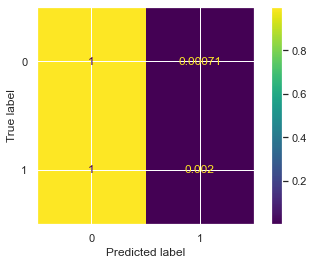

In [21]:
score_and_matrix(rf, X_test, X_train, y_train, y_test)

Unfortunately, we have a model that is just labelling everything as a 'good' post (target of 0). This may be due to class imbalance:

In [22]:
pd.Series(y_test).value_counts()

0    16829
1     3471
dtype: int64

### 1.1.1 W/ Metadata

Let's now try to incorporate metadata (time of posting) into the dataset and see if that impacts performance.

In [23]:
a_3 = time_slice(a_all, 2015, 6, 2016, 1)
q_3 = time_slice(q_all, 2015, 6, 2016, 1)

In [24]:
def q_prep2(data_q, data_a):
    """
    Second iteration of prep function.
    This is similar to the earlier function, now with added metadata:
        year
        month
        dayofweek
        hour
    
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['target'] = df['answer_count'].map(lambda x: 0 if x > 0 else 1)
    
    df['year'] = q_3['CreationDate'].map(lambda x: x.year)
    df['month'] = q_3['CreationDate'].map(lambda x: x.month)
    df['dayofweek'] = q_3['CreationDate'].map(lambda x: x.dayofweek)
    df['hour'] = q_3['CreationDate'].map(lambda x: x.hour)
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df[['text', 'target', 'year', 'month', 'dayofweek', 'hour']]

In [25]:
q_4 = q_prep2(q_3, a_3)

In [26]:
q_4.sample(10)

,text,target,year,month,dayofweek,hour
428982,Python while loop speed <p>I would like it if ...,0,2015,8,6,0
439771,How do you split a string in Python with multi...,0,2015,9,2,0
461792,"TypeError: argument 1 must be pygame.Surface, ...",0,2015,11,6,23
472177,upload image on json DJANGO REST FRAMEWORK <p>...,0,2015,12,2,21
404522,Change Window on Tkinter <p>How do I change a ...,0,2015,6,2,15
401023,DistributionNotFound error with pydev on exter...,0,2015,6,0,18
457855,Why is this python code giving NZEC at HackerE...,1,2015,11,4,14
438281,django python dynamic max_length based on sele...,0,2015,9,4,9
435770,"Qt Designer set ""View Code"" to always show Pyt...",0,2015,9,4,6
398058,IndexError when trying to execute a Script <p>...,0,2015,6,6,9


In [27]:
w2v = W2vVectorizer(glove)
q_4_data = w2v.transform(q_4['text'])

q_4_df = pd.DataFrame(q_4_data)

for col in ['year', 'month', 'dayofweek', 'hour']:
    q_4_df[col] = list(q_4[col])
    
q_4_df.columns = [str(x) for x in q_4_df.columns]

In [28]:
y_4 = q_4['target']

In [29]:
q_5 = q_4_df

In [30]:
X_train, X_test, y_train, y_test = train_test_split(q_5, y_4,\
                                                    test_size = 0.25, random_state = 42)

In [31]:
rf = RandomForestClassifier(n_estimators=100, verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   49.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


accuracy : 0.8288177339901478
balanced accuracy : 0.49999549761297307
recall : 0.0002881014116969173
precision : 0.16666666666666666


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


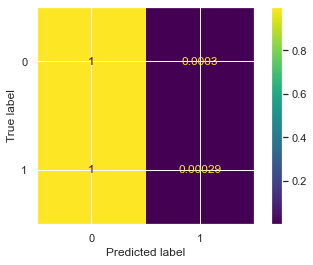

In [32]:
score_and_matrix(rf, X_test, X_train, y_train, y_test)

Again, we see a similar lackluster result.

## 1.2 BoW

Let's look at using a simpler vectorization process, Tfid.

In [33]:
vectorizer = TfidfVectorizer()

In [34]:
q_1['text'] = q_1['text'].apply(clean_text)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(q_1['text'], q_1['target'],\
                                                    test_size = 0.25, random_state = 42)

In [36]:
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

In [37]:
for vec in [vec_train, vec_test]:
    print(vec.shape)

(60899, 330211)
(20300, 330211)


In [38]:
non_zero_cols = vec_train.nnz / float(vec_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(vec_test.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 89.78612128277969
Percentage of columns containing 0: 0.9997280946991991


In [39]:
bow_nb = MultinomialNB()
bow_rf = RandomForestClassifier(n_estimators=100)

In [40]:
bow_nb.fit(vec_train, y_train)
nb_train_pred = bow_nb.predict(vec_train)
nb_test_pred = bow_nb.predict(vec_test)

In [41]:
bow_rf.fit(vec_train, y_train)
rf_train_pred = bow_rf.predict(vec_train)
rf_test_pred = bow_rf.predict(vec_test)

In [42]:
nb_train_score = accuracy_score(y_train, nb_train_pred)
nb_test_score = accuracy_score(y_test, nb_test_pred)
rf_train_score = accuracy_score(y_train, rf_train_pred)
rf_test_score = accuracy_score(y_test, rf_test_pred)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}"\
      .format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}"\
      .format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.8285 		 Testing Accuracy: 0.8289

----------------------------------------------------------------------

Random Forest
Training Accuracy: 1.0 		 Testing Accuracy: 0.8289


accuracy : 0.828768472906404
balanced accuracy : 0.5000801270816714
recall : 0.0005762028233938346
precision : 0.2222222222222222


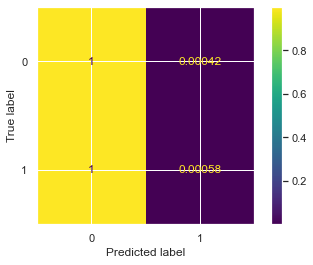

In [43]:
score_and_matrix(bow_rf, vec_test, vec_train, y_train, y_test)

accuracy : 0.8289162561576354
balanced accuracy : 0.49994057876284986
recall : 0.0
precision : 0.0


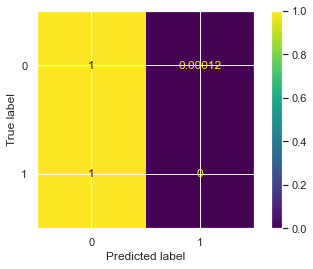

In [44]:
score_and_matrix(bow_nb, vec_test, vec_train, y_train, y_test)

Again, we see a similar pattern. 

### Random Over-Sampling

Let's try using ROS (Random Over-Sampling) to balance the classes.

In [45]:
ROS = RandomOverSampler()

X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

accuracy : 0.6486699507389162
balanced accuracy : 0.6466651803653676
recall : 0.6436185537309133
precision : 0.27481855086726537


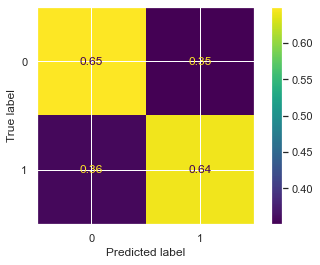

In [46]:
score_and_matrix(bow_nb, vec_test, X_train_ros, y_train_ros, y_test)

accuracy : 0.8281773399014778
balanced accuracy : 0.5029251221024251
recall : 0.00864304235090752
precision : 0.38961038961038963


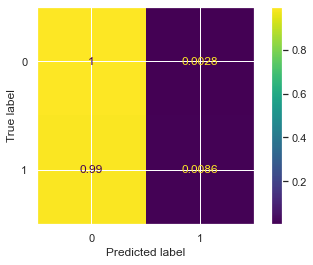

In [47]:
score_and_matrix(bow_rf, vec_test, X_train_ros, y_train_ros, y_test)

In [48]:
# I also wanted to try the XGBoost classifier again as well, to see if the ROS has an effect.

xgb = XGBClassifier(n_estimators=200, max_depth=20, verbosity=1, learning_rate=.5)
xgb.fit(X_train_ros, y_train_ros)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

/Users/will/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


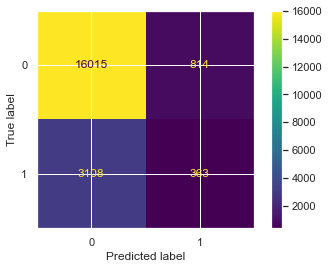

In [49]:
plot_confusion_matrix(xgb, vec_test, y_test)

We finally see a promising result with the Multinomial Naive Bayes model, since it's able to distinguish between the two classes, and has a similar level of accuracy with both being around %65 True Positive/True Negative.

### Changing Target Calculation

However, I'd like to also explore the ability of a model to make further gradations in question quality, to see if the model is able to pick up on a post's score as well.

In [50]:
def q_prep3(data_q, data_a):
    """
    Function to prep the Questions dataframe (first stage)
    Returns dataframe with added features:
        answer_count : # of answers the question received
        target : quality of the question (inverse - lower score, higher quality)
            0 : score > 0 AND answer_count > 0
            1 : score <= 0 AND answer_count > 0
            2 : score > 0 AND answer_count == 0
            3 : score <= 0 AND answer_count ==0
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 'text' and 'target' columns
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['target1'] = df['Score'].map(lambda x: 0 if x > 0 else 1)
    df['target2'] = df['answer_count'].map(lambda x: 0 if x > 0 else 2)
    df['target'] = df['target1'] + df['target2']
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df[['text', 'target']]

In [51]:
a_6 = time_slice(a_all, 2015, 6, 2016, 1)
q_6 = time_slice(q_all, 2015, 6, 2016, 1)

In [52]:
q_6 = q_prep3(q_6, a_6)

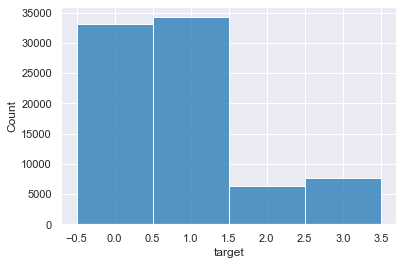

In [53]:
# quick check of class balance
sns.histplot(data=q_6, x='target', discrete=True);

In [54]:
q_6['text'] = q_6['text'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(q_6['text'], q_6['target'],\
                                                    test_size = 0.25, random_state = 42)

vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

ROS = RandomOverSampler()

X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

In [55]:
# an altered score/matrix function, to deal with >2 classes

def score_and_matrix_multi(clf, X_test, X_train, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    tests = [('accuracy', accuracy_score), ('balanced accuracy', balanced_accuracy_score),\
            ('recall', recall_score), ('precision', precision_score)]
    for test, tester in tests:
        if test in ['recall', 'precision']:
            print(test,':',tester(y_test, y_pred, average=None))
        else:
            print(test,':',tester(y_test, y_pred))

accuracy : 0.3721182266009852
balanced accuracy : 0.37540713749985943
recall : [0.4135967  0.33496561 0.47563353 0.27743271]
precision : [0.51579266 0.55710685 0.14634146 0.15209989]


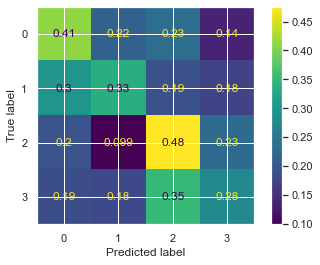

In [56]:
bow_nb = MultinomialNB()

score_and_matrix_multi(bow_nb, vec_test, X_train_ros, y_train_ros, y_test)

### Different approach to text cleaning

I'd like to try a different text cleaning method, incorporating some of the Gensim methods (removing stopwords, stemming, etc)

In [57]:
filters = [gsp.strip_tags,
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text_2(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [58]:
def test_model(prep_func, text_cleaner, clf, dates=[(2015,6),(2016,1)]):
    print('Slicing data...')
    a_df = time_slice(a_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    q_df = time_slice(q_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    
    print('Prepping data...')
    q_df = prep_func(q_df, a_df)
    
    print('Cleaning text...')
    q_df['text'] = q_df['text'].apply(text_cleaner)
    
    print('Splitting train/test sets...')
    X_train, X_test, y_train, y_test = train_test_split(q_df['text'], q_df['target'],\
                                                        test_size = 0.25, random_state = 42)
    print('Vectorizing data...')
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()
    
    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)
    
    print('Fitting model...')
    score_and_matrix_multi(clf, vec_test, X_train_ros, y_train_ros, y_test)

Slicing data...
Prepping data...
Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
Fitting model...
accuracy : 0.3660591133004926
balanced accuracy : 0.37023529539114913
recall : [0.4037809  0.33076833 0.45808967 0.28830228]
precision : [0.50932437 0.5404839  0.14708951 0.14989236]


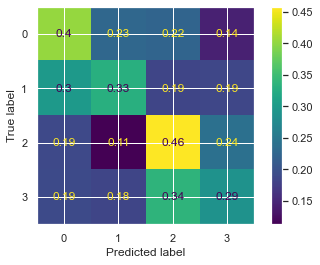

In [59]:
test_model(q_prep3, clean_text_2, bow_nb)

Again, fairly lackluster results. Using the 'score' data doesn't seem to help the model at all.

***

## Using 60k SO Questions

To switch gears, I'll use some similar methods to try and model the question quality using the "60k Stack Overflow Questions with Quality Rating" dataset:

https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate

This is a much smaller dataset, but includes very useful target information, and perhaps includes question data that was closed/edited, thus giving the model a chance to look at 'actual' low quality posts, as opposed to just lower-performing posts in the Python dataset, that were ultimately not removed or edited.

In [60]:
data2 = pd.read_csv('../data/Quality_60k/train.csv')
data2_valid = pd.read_csv('../data/Quality_60k/valid.csv')

In [61]:
data2.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


In [62]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            45000 non-null  int64 
 1   Title         45000 non-null  object
 2   Body          45000 non-null  object
 3   Tags          45000 non-null  object
 4   CreationDate  45000 non-null  object
 5   Y             45000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


In [63]:
def test_models(df, text_cleaner, models):
    print('Cleaning text...')
    df['text'] = (df['Title']+' '+df['Body']).apply(text_cleaner)

    df['target'] = df['Y'].map(lambda x: 1 if x=='HQ' else 0)

    print('Splitting train/test sets...')
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],\
                                                      test_size = 0.2, random_state = 42)
    print('Vectorizing data...')
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)
    
    for model, clf in models:
        print('='*70)
        print(f'Fitting {model} model...')
        score_and_matrix(clf, vec_test, X_train_ros, y_train_ros, y_test)
        plt.show()

In [64]:
rf =  ('Random Forest', RandomForestClassifier(n_estimators=50))
svc = ('Support Vector Machine', LinearSVC())
lr = ('Logistic Regression', LogisticRegression(max_iter=1000))
xgb = ('XGBoost', xgboost.XGBClassifier())
nb = ('Naive Bayes', MultinomialNB())

models = [rf, svc, lr, xgb, nb]

## Baseline models

Based on work above, I'll stick with the basic outline of methods used in the highest-performing model thus far:
* Tf-Idf vectorizer
* First text cleaning method
* Random over-sampling

Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
Fitting Random Forest model...
accuracy : 0.8261111111111111
balanced accuracy : 0.765340041438992
recall : 0.5871838111298482
precision : 0.8362151777137368


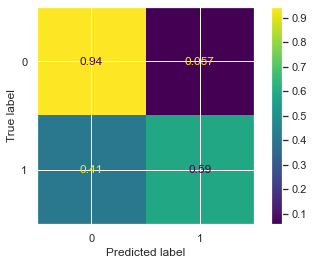

Fitting Support Vector Machine model...
accuracy : 0.8631111111111112
balanced accuracy : 0.8518627287981435
recall : 0.8188870151770657
precision : 0.7774575728466219


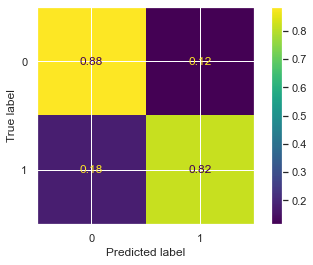

Fitting Logistic Regression model...
accuracy : 0.8635555555555555
balanced accuracy : 0.8610298832974037
recall : 0.8536256323777403
precision : 0.761203007518797


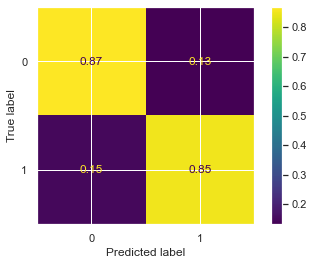

Fitting XGBoost model...
accuracy : 0.8582222222222222
balanced accuracy : 0.8431560696387431
recall : 0.7989881956155144
precision : 0.7769760577238439


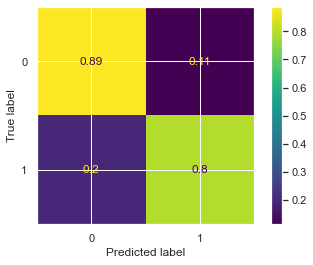

Fitting Naive Bayes model...
accuracy : 0.8246666666666667
balanced accuracy : 0.8413828272681422
recall : 0.8903878583473862
precision : 0.6781402517338814


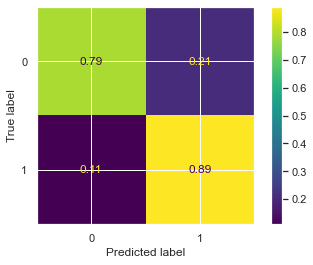

In [65]:
test_models(data2, clean_text, models)

Because of the best/most balanced results coming from the Logistic Regression model, I'll do a little parameter tuning:

In [66]:
def grid_search_lr(df, text_cleaner):
    print('Cleaning text...')
    df['text'] = (df['Title']+' '+df['Body']).apply(text_cleaner)

    df['target'] = df['Y'].map(lambda x: 1 if x=='HQ' else 0)

    print('Splitting train/test sets...')
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],\
                                                      test_size = 0.2, random_state = 42)
    print('Vectorizing data...')
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)
    
    for solver, penalty in [
        ('newton-cg', 'l2'),
        ('liblinear', 'l1'), ('liblinear', 'l2'),
        ('lbfgs', 'l2')
    ]:
        for C in [.1, 1, 10]:
            t0 = time()
            print('='*70)
            print(f"Testing solver:{solver} | penalty:{penalty} | C={C}")
            lr = LogisticRegression( penalty=penalty, solver=solver, C=C, max_iter=1000)
            score_and_matrix(lr, vec_test, X_train_ros, y_train_ros, y_test)
            plt.show()
            print(f"training time: {time()-t0}")

## First round of hyperparameter tuning

Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
Testing solver:newton-cg | penalty:l2 | C=0.1
accuracy : 0.8401111111111111
balanced accuracy : 0.8414897080129822
recall : 0.845531197301855
precision : 0.71875


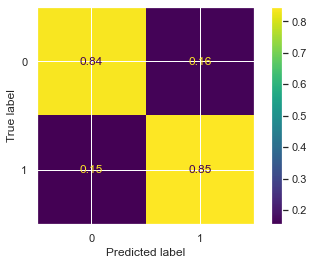

training time: 1.2519397735595703
Testing solver:newton-cg | penalty:l2 | C=1
accuracy : 0.8622222222222222
balanced accuracy : 0.8600356828003035
recall : 0.8536256323777403
precision : 0.7584656877434822


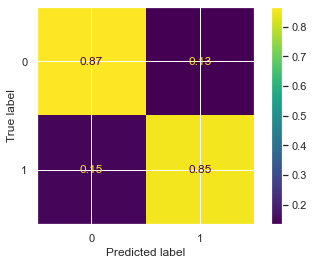

training time: 1.4440739154815674
Testing solver:newton-cg | penalty:l2 | C=10
accuracy : 0.8631111111111112
balanced accuracy : 0.8520342968434553
recall : 0.8195615514333895
precision : 0.7771026543012473


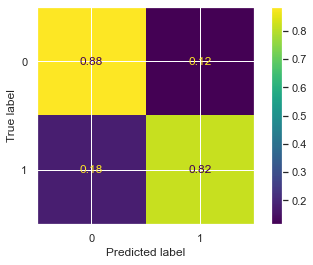

training time: 2.1148481369018555
Testing solver:liblinear | penalty:l1 | C=0.1
accuracy : 0.8115555555555556
balanced accuracy : 0.8137634456675575
recall : 0.8202360876897133
precision : 0.6764951321279555


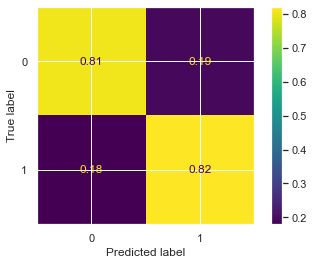

training time: 0.4712667465209961
Testing solver:liblinear | penalty:l1 | C=1
accuracy : 0.8593333333333333
balanced accuracy : 0.8574526616099734
recall : 0.8519392917369308
precision : 0.7533552042946615


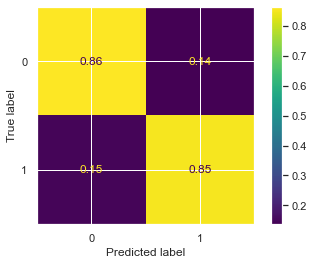

training time: 0.7892520427703857
Testing solver:liblinear | penalty:l1 | C=10
accuracy : 0.8511111111111112
balanced accuracy : 0.8336502498774014
recall : 0.7824620573355818
precision : 0.7694859038142621


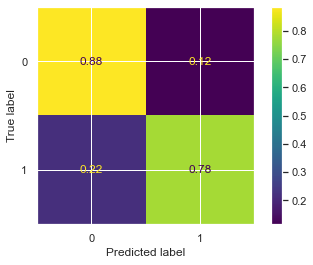

training time: 2.515887975692749
Testing solver:liblinear | penalty:l2 | C=0.1
accuracy : 0.8404444444444444
balanced accuracy : 0.8418240421599131
recall : 0.8458684654300168
precision : 0.7192429022082019


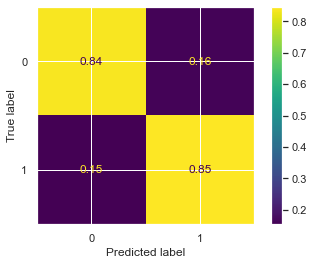

training time: 1.4492690563201904
Testing solver:liblinear | penalty:l2 | C=1
accuracy : 0.8621111111111112
balanced accuracy : 0.8599528327588783
recall : 0.8536256323777403
precision : 0.7582384661473937


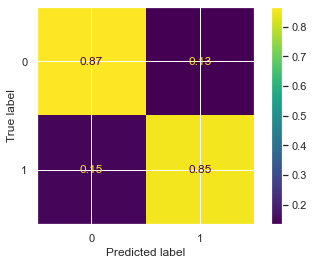

training time: 2.710381031036377
Testing solver:liblinear | penalty:l2 | C=10
accuracy : 0.8631111111111112
balanced accuracy : 0.8520342968434553
recall : 0.8195615514333895
precision : 0.7771026543012473


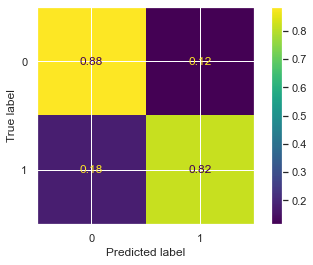

training time: 4.988495111465454
Testing solver:lbfgs | penalty:l2 | C=0.1
accuracy : 0.8401111111111111
balanced accuracy : 0.8414897080129822
recall : 0.845531197301855
precision : 0.71875


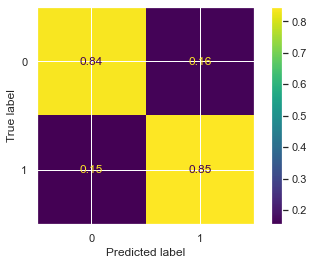

training time: 2.059215784072876
Testing solver:lbfgs | penalty:l2 | C=1
accuracy : 0.8621111111111112
balanced accuracy : 0.8599528327588783
recall : 0.8536256323777403
precision : 0.7582384661473937


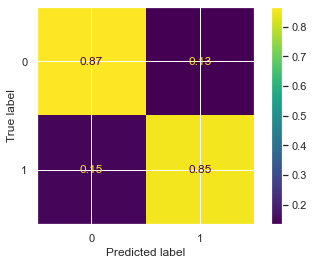

training time: 3.0908498764038086
Testing solver:lbfgs | penalty:l2 | C=10
accuracy : 0.8631111111111112
balanced accuracy : 0.8520342968434553
recall : 0.8195615514333895
precision : 0.7771026543012473


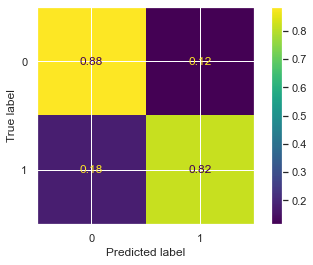

training time: 6.684750080108643


In [67]:
grid_search_lr(data2, clean_text)

## Second round of hyperparameter tuning

In [68]:
def grid_search_lr_2(df, text_cleaner):
    print('Cleaning text...')
    df['text'] = (df['Title']+' '+df['Body']).apply(text_cleaner)

    df['target'] = df['Y'].map(lambda x: 1 if x=='HQ' else 0)

    print('Splitting train/test sets...')
    
    X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],\
                                                      test_size = 0.2, random_state = 42)
    print('Vectorizing data...')
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)
    
    for solver, penalty in [
        ('lbfgs', 'l2')
    ]:
        for C in [1, 1.5, 2, 5]:
            t0 = time()
            print('='*70)
            print(f"Testing solver:{solver} | penalty:{penalty} | C={C}")
            lr = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter=1000)
            score_and_matrix(lr, vec_test, X_train_ros, y_train_ros, y_test)
            plt.show()
            print(f"training time: {time()-t0}")

Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
Testing solver:lbfgs | penalty:l2 | C=1
accuracy : 0.8614444444444445
balanced accuracy : 0.8585978922837691
recall : 0.8502529510961214
precision : 0.7584235860409145


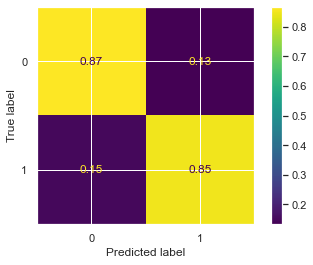

training time: 3.1547577381134033
Testing solver:lbfgs | penalty:l2 | C=1.5
accuracy : 0.8631111111111112
balanced accuracy : 0.8595832908371766
recall : 0.8492411467116358
precision : 0.7623372691492583


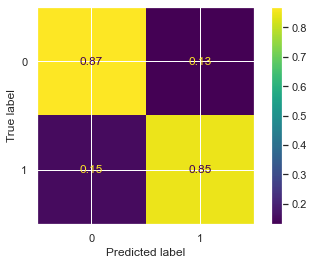

training time: 2.981843948364258
Testing solver:lbfgs | penalty:l2 | C=2
accuracy : 0.8646666666666667
balanced accuracy : 0.8598853511905676
recall : 0.8458684654300168
precision : 0.767207096971551


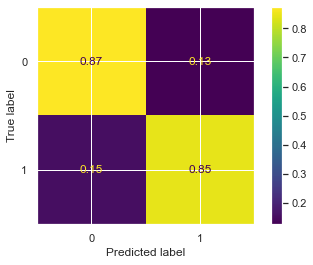

training time: 3.475912094116211
Testing solver:lbfgs | penalty:l2 | C=5
accuracy : 0.8647777777777778
balanced accuracy : 0.856279488257788
recall : 0.8313659359190556
precision : 0.7746700188560653


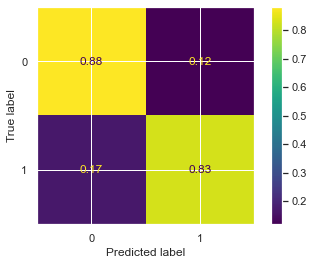

training time: 5.098950147628784


In [69]:
grid_search_lr_2(data2, clean_text)

## Testing multiple random splits for validation

In [70]:
def cross_val_lr(df, text_cleaner):
    print('Cleaning text...')
    df['text'] = (df['Title']+' '+df['Body']).apply(text_cleaner)

    df['target'] = df['Y'].map(lambda x: 1 if x=='HQ' else 0)
    bal_acc_scores = []
    for r in list(range(1,6)):
        print('Splitting train/test sets...')
        X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'],\
                                                          test_size = 0.2, random_state = r)
        print('Vectorizing data...')
        vec_train = vectorizer.fit_transform(X_train)
        vec_test = vectorizer.transform(X_test)

        ROS = RandomOverSampler()

        print('Random over-sampling...')
        X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

        t0 = time()
        print('='*70)
        lr = LogisticRegression(C=1.5, max_iter=1000)
        score_and_matrix(lr, vec_test, X_train_ros, y_train_ros, y_test)
        plt.show()
        print(f"training time: {time()-t0}")
        bal_acc_scores.append(balanced_accuracy_score(y_test, lr.predict(vec_test)))
    return bal_acc_scores

Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
accuracy : 0.8633333333333333
balanced accuracy : 0.858774135527856
recall : 0.8449304174950298
precision : 0.769927536231884


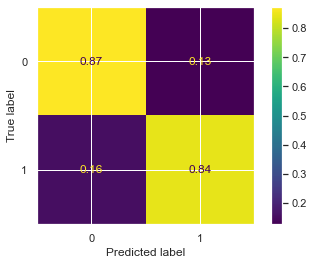

training time: 3.1787571907043457
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
accuracy : 0.864
balanced accuracy : 0.8595960497753585
recall : 0.8460777851021754
precision : 0.7722623345367028


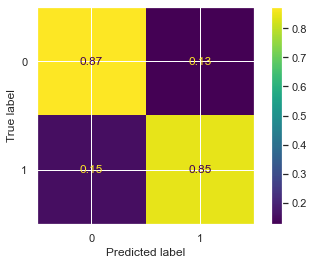

training time: 4.115534067153931
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
accuracy : 0.8655555555555555
balanced accuracy : 0.8627952421084187
recall : 0.8545636910732196
precision : 0.7673371359951966


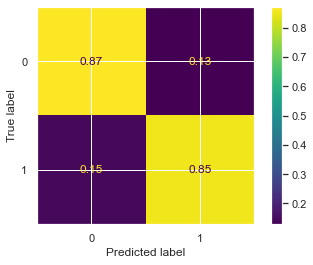

training time: 2.7575807571411133
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
accuracy : 0.8614444444444445
balanced accuracy : 0.8564313671432808
recall : 0.8415410385259632
precision : 0.7644552647595861


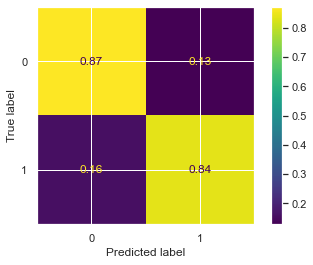

training time: 2.8155810832977295
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
accuracy : 0.8615555555555555
balanced accuracy : 0.8584535287584797
recall : 0.8489445910290238
precision : 0.7656157049375372


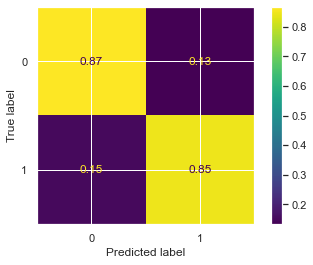

training time: 2.9032859802246094


[0.858774135527856,
 0.8595960497753585,
 0.8627952421084187,
 0.8564313671432808,
 0.8584535287584797]

In [71]:
cross_val_lr(data2, clean_text)

In [72]:
np.mean([0.8607681892596278,
         0.8604982176521714,
         0.8607097711840799,
         0.8547663504555195,
         0.8602648602573444])

0.8594014777617487

Besides the adjustment of C to 1.5, there's not much more to tune on these models, and I'm fairly pleased with the .87/.85 accuracy of this final model.

This means that a large majority of both classes are correctly predicted, and this wouldn't lead to a massive amount of false negatives/positives which would annoy users who write good questions, and wouldn't catch poor quality posts.

## Final Model - Testing on Holdout Set

In [73]:
def quality_test(df1, df2, text_cleaner):
    print('Cleaning text...')
    df = pd.concat([df1, df2], ignore_index=True)
    df['text'] = (df['Title']+' '+df['Body']).apply(text_cleaner)

    df['target'] = df['Y'].map(lambda x: 1 if x=='HQ' else 0)
    
    print('Splitting train/test sets...')
    df_train = df.iloc[:-15000]
    df_test = df.iloc[-15000:]
    
    X_train = df_train['text']
    X_test = df_test['text']
    y_train = df_train['target']
    y_test = df_test['target']
    
    print('Vectorizing data...')
    vectorizer = TfidfVectorizer()
    vec_train = vectorizer.fit_transform(X_train)
    vec_test = vectorizer.transform(X_test)

    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

    t0 = time()
    print('='*70)
    lr = LogisticRegression(C=1.5, max_iter=1000)
    fig, ax = plt.subplots(figsize=(8,8))
    lr.fit(X_train_ros, y_train_ros)
    y_pred = lr.predict(vec_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true',
                                            values_format='.1%',
                                            ax=ax, colorbar=False)
    ax.set_xticklabels(['LQ', 'HQ'])
    ax.set_yticklabels(['LQ', 'HQ'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.title('Results: Actual vs. Predicted Quality')
    print(f"training time: {time()-t0}")

Cleaning text...
Splitting train/test sets...
Vectorizing data...
Random over-sampling...
training time: 3.7865588665008545


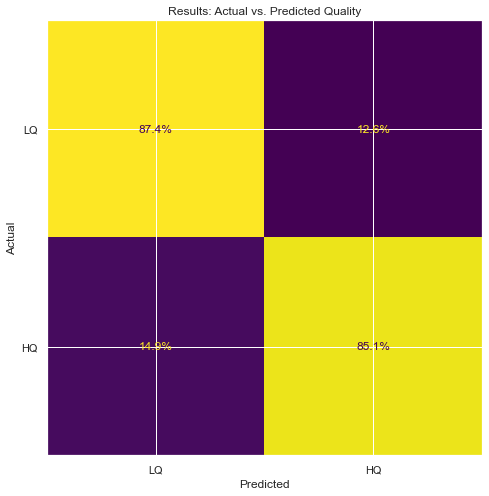

In [74]:
quality_test(data2, data2_valid, clean_text)

### Generalize to Bigger Dataset?

I'd like to also see if this model has any ability to predict the original quality indicators of the Python dataset.

In [75]:
def q_prep4(data_q, data_a):
    """
    Simpler version of function to prep the Questions dataframe (first stage)
    Returns dataframe with added feature:
        answer_count : # of answers the question received
    
    Args:
    
    data_q : questions dataframe
    data_a : answers dataframe
    
    Returns:
    
    dataframe with 
    """
    df = data_q.copy()
    df_a = data_a.copy()
    
    ids = list(df['Id'])
    df['answer_count'] = [len(df_a[df_a['ParentId']==x]) for x in ids]
    
    df['text'] = df['Title'] + ' ' + df['Body']
    
    return df

In [76]:
def fit_models(df_sm, prep_func, text_cleaner, models, dates=[(2016,1),(2016,11)]):
    print('Slicing data...')
    a_df = time_slice(a_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    df = time_slice(q_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
    
    print('Prepping data...')
    df = prep_func(df, a_df)
    
    print('Cleaning text...')
    df['text'] = df['text'].apply(text_cleaner)
    df_sm['text'] = (df_sm['Title']+' '+df_sm['Body']).apply(text_cleaner)

    df_sm['target'] = df_sm['Y'].map(lambda x: 1 if x=='HQ' else 0)
    
    print('Vectorizing data...')
    X_2 = vectorizer.fit_transform(df_sm['text'])
    X = vectorizer.transform(df['text'])
    
    ROS = RandomOverSampler()

    print('Random over-sampling...')
    X_2, y_2 = ROS.fit_resample(X_2, df_sm['target'])
    
    final_models = []
    
    for model, clf in models:
        print('='*70)
        print(f'Fitting using {model} model...')
        clf.fit(X_2, y_2)
        
        final_models.append((model, clf))
    
    return {'final_models':final_models, 'X':X}

In [77]:
fitted_models = fit_models(data2, q_prep4, clean_text, models)

Slicing data...
Prepping data...
Cleaning text...
Vectorizing data...
Random over-sampling...
Fitting using Random Forest model...
Fitting using Support Vector Machine model...
Fitting using Logistic Regression model...
Fitting using XGBoost model...
Fitting using Naive Bayes model...


In [78]:
lr_fit = fitted_models['final_models'][2][1]
df_text = fitted_models['X']
y_pred = lr_fit.predict(df_text)

In [79]:
dates=[(2016,1),(2016,11)]
new_df = time_slice(q_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
new_df_a = time_slice(a_all, dates[0][0], dates[0][1], dates[1][0], dates[1][1])
new_df = q_prep4(new_df, new_df_a)

In [80]:
new_df['target']=y_pred

In [81]:
new_df.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,answer_count,text,target
476742,34552552,5732525.0,2016-01-01 00:00:39,2,Selenium Firefox webdriver won't load a blank ...,<p>everyone. </p>\n\n<p>Main question: I am us...,1,Selenium Firefox webdriver won't load a blank ...,1
476743,34552584,5635159.0,2016-01-01 00:07:19,1,Is there any chance I got memory leak with pyt...,<p>Happy new year to all of you!\nI trained a ...,0,Is there any chance I got memory leak with pyt...,1
476744,34552670,1876983.0,2016-01-01 00:26:13,1,Why is my Runge-Kutta Python script defining e...,"<p>I am a newcomer to Python, my knowledge of ...",1,Why is my Runge-Kutta Python script defining e...,1
476745,34552671,5731951.0,2016-01-01 00:26:25,0,Frequency to Midi Converter python math error,"<p>This is a frequency to midi note converter,...",2,Frequency to Midi Converter python math error ...,0
476746,34552706,4180276.0,2016-01-01 00:35:34,0,Stream file to iphone with flask,<p>I am currently doing a file conversion on t...,0,Stream file to iphone with flask <p>I am curre...,1


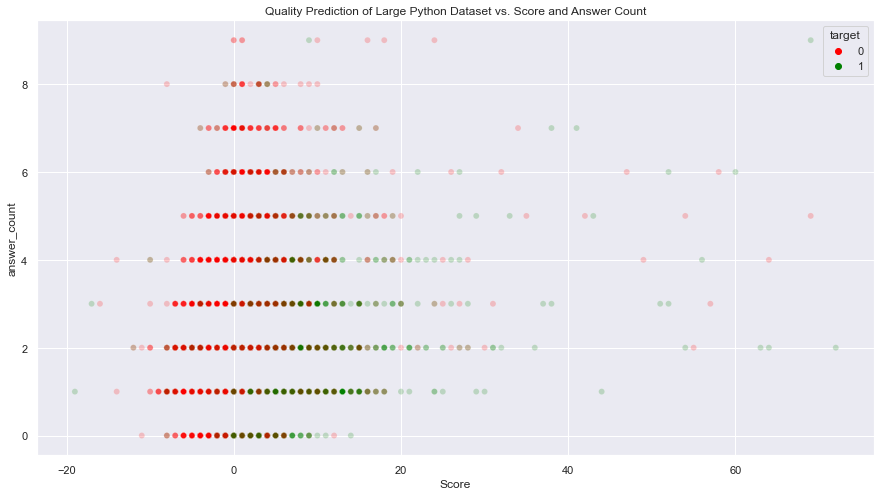

In [82]:
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=new_df[(new_df['answer_count']<10) & (new_df['Score']<75)],\
                y='answer_count', x='Score', hue='target', alpha=.2, palette=['r','g'])
ax.set_title('Quality Prediction of Large Python Dataset vs. Score and Answer Count');

This at least shows that the model does have an ability to say something about the larger dataset - if we had access to similar data on the scale of the Python dataset, this would likely be even more effective.

In [83]:
new_df1 = new_df[new_df['target']==1]
new_df0 = new_df[new_df['target']==0]

In [84]:
new_df1.answer_count.mean()

0.9927157757698805

In [85]:
new_df0.answer_count.mean()

1.3694048502658407

In [86]:
len(new_df0[new_df0['answer_count']==0])/len(new_df0), len(new_df0[new_df0['answer_count']>0])/len(new_df0)

(0.18066558613690414, 0.8193344138630959)

In [87]:
len(new_df1[new_df1['answer_count']==0])/len(new_df1), len(new_df1[new_df1['answer_count']>0])/len(new_df1)

(0.2768315174433923, 0.7231684825566077)

In [88]:
new_df1.Score.mean()

0.7834570618229159

In [89]:
new_df0.Score.mean()

0.3786297468833785

In [90]:
len(new_df1), len(new_df0)

(64523, 66017)

And above, these average scores and value counts show that the model does somewhat well at correllating the 'quality' target to posts' scores, but the answer_count is not correlated at all.

*********************
<a id="a_q"></a>
# 2. Answer Quality
[Back to Top](#top) | [Previous Section](#q_q) | [Next Section](#t_p)

In this section, I will employ similar techniques to try and predict the Score of answers submitted to questions.

In [91]:
a_all = pd.read_csv('../data/QA_python/Answers.csv', encoding='latin1')

In [92]:
a_all.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B..."


In [93]:
# I'll define 'low quality' as having a score of 0 or lower, and 'high quality' as anything above 0.
def a_target(x):
    if x > 0:
        return 1
    else:
        return 0

a_all['target'] = a_all['Score'].map(a_target)

In [94]:
a_all.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,target
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,1
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,1
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...,1
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,1
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",1


In [95]:
a_all['CreationDate'] = pd.to_datetime(a_all['CreationDate'], infer_datetime_format=True) 

In [96]:
a2 = time_slice(a_all, 2015, 6, 2016, 1)
len(a2)

116082

In [97]:
len(a2[a2['target']==1])

68803

In [98]:
len(a2[a2['target']==0])

47279

In [99]:
# Re-formualation of the text cleaning function.

filters = [gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text_3(s):
    # remove code
    s = re.sub('<pre><code>.*?</code></pre>', '', s)
    # remove html tags
    s = re.compile(r'<.*?>').sub(r'', s)
    # remove links
    s = re.compile(r'https?://\S+|www\.\S+').sub(r'', s)
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [100]:
a2['text'] = a2['Body'].map(clean_text_3)
a2.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,target,text
697812,30563958,849891.0,2015-06-01 00:00:00,30553925,6,"<p>The odds, i.e. 2-coprimes, are generated by...",1,odd coprim gener roll wheel repeat addit start...
697813,30563963,3842697.0,2015-06-01 00:00:44,30563725,1,<p>I think the issue here is that you're attem...,1,think issu attempt valu entri self app mainloo...
697814,30563970,400617.0,2015-06-01 00:01:53,30563807,2,"<p>If you want to make the ""long"" function cal...",1,want long function decor function result exact...
697815,30563976,4621258.0,2015-06-01 00:02:57,30560168,1,"<p>For users of Ubuntu, a solution does exist....",1,user ubuntu solut exist enter synapt packag ma...
697816,30563983,359284.0,2015-06-01 00:04:05,30541152,1,<p>The problem you are seeing is that you are ...,1,problem see modifi serial data outsid actual p...


In [101]:
rf =  ('Random Forest', RandomForestClassifier(n_estimators=100))
svc = ('Support Vector Machine', LinearSVC())
lr = ('Logistic Regression', LogisticRegression(max_iter=1000))
xgb = ('XGBoost', xgboost.XGBClassifier())
nb = ('Naive Bayes', MultinomialNB())

models = [rf, svc, lr, xgb, nb]

Vectorizing data...
Random over-sampling...
Fitting Random Forest model...
accuracy : 0.6055476590429427
balanced accuracy : 0.569676494028302
recall : 0.7705013886858646
precision : 0.6365942028985507


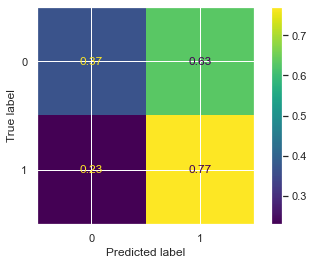

Fitting Support Vector Machine model...
accuracy : 0.5785415859068785
balanced accuracy : 0.5692532156166584
recall : 0.6212542026019587
precision : 0.6487064031137907


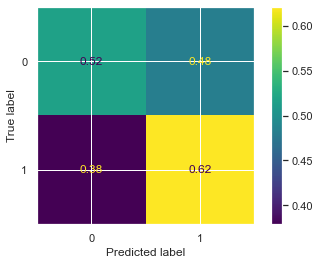

Fitting Logistic Regression model...
accuracy : 0.5858207348063919
balanced accuracy : 0.5808649681310909
recall : 0.6086098523607659
precision : 0.661503018748014


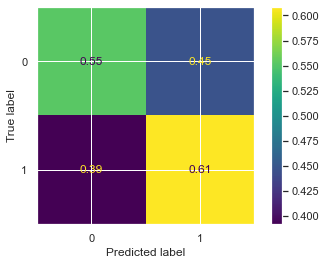

Fitting XGBoost model...
accuracy : 0.5754834819313435
balanced accuracy : 0.5807247734460175
recall : 0.5513813769916679
precision : 0.6698632569703428


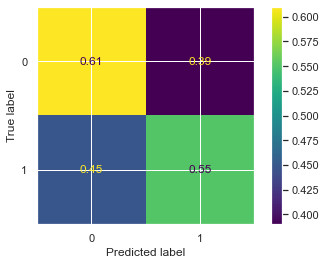

Fitting Naive Bayes model...
accuracy : 0.5827626308308567
balanced accuracy : 0.5744239653767151
recall : 0.6211080251425231
precision : 0.6536420275363434


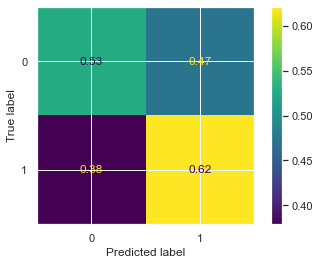

In [102]:
X_train, X_test, y_train, y_test = train_test_split(a2['text'], a2['target'],\
                                                      test_size = 0.2, random_state = 42)
print('Vectorizing data...')
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

ROS = RandomOverSampler()

print('Random over-sampling...')
X_train_ros, y_train_ros = ROS.fit_resample(vec_train, y_train)

for model, clf in models:
    print('='*70)
    print(f'Fitting {model} model...')
    score_and_matrix(clf, vec_test, X_train_ros, y_train_ros, y_test)
    plt.show()

Because of poor results, time constraints, and the lack of a similar alternate dataset (like the 60k quality-rated questions) I'll abandon the answer quality modelling component.

*********************
<a id="t_p"></a>
# 3. Tag Prediction
[Back to Top](#top) | [Previous Section](#a_q) | [Next Section](#bottom)

For this section, I'll attempt to model and predict posts' tags. This is a more complex problem than predicting quality, since there are potentially as many target classes as there are tags, and any question can have one or many tags associated with it.

In addition, once I am able to build a basic model, I'll target the ability of the model to predict the correct tags in its 'top 20' tags predicted, as this will enable a feature to suggest 20 tags for a given question, which the user can use to select which tags apply to the post.

***

## Features and Target

As with earlier sections, the feature set is the text data itself.

The 'target' in this case is the tag or tags for each question. Since any post can have 1 to 5 tags, and they are not mutually exclusive, this means that there are as many target classes as there are tags (in the model - I will have to limit the target classes to the most-used tags). Thus, Multi-Label Classification is required to predict what tags will apply to a given post.

In addition, since I want to implement a top-20 suggested tags list, as opposed to simply predicting a discrete set of tags, I'll have to determine how to measure the model's performance in that context.

***

## Target metrics

There are two areas of metrics I will use to evaluate model performance:

* Hamming Loss
    * This is a loss measure for multi-label problems, which gives a score from 0.0 to 1.0 (1.0 is complete loss, and 0.0 is 'perfect' prediction)
    * In-depth paper on multi-label algorithms, with lots of info about hamming loss:
        * <a id="https://www.researchgate.net/profile/Mohammad-Sorower-2/publication/266888594_A_Literature_Survey_on_Algorithms_for_Multi-label_Learning/links/57fdb69308ae6750f80665b5/A-Literature-Survey-on-Algorithms-for-Multi-label-Learning.pdf">Sorower, Mohammad. (2023). A Literature Survey on Algorithms for Multi-label Learning.</a> 

* Top-20 Metrics
    * After generating the top-20 list (with predicted probabilities for each tag) I can calculate the scores for:
        * Each post's % of tags correctly predicted to be in the top-20 list, and then the avg. across all posts
        * Avg. suggestion rate across all tags
        * % of posts with perfect suggestion rates
***


In [103]:
tags_all = pd.read_csv('../data/QA_python/Tags.csv')

In [104]:
tags_all.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [105]:
print(len(tags_all.Tag.unique()) , 'unique tags')

16896 unique tags


In [106]:
q14 = time_slice(q_all, 2014, 1, 2014, 4)
q14.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
233194,20864531,805981.0,2014-01-01 00:26:39,0,How to create tables for flask app using peewe...,<p>I'm new to peewee orm. </p>\n\n<p>Peewee us...
233195,20864554,523463.0,2014-01-01 00:32:49,1,Getting a 'got multiple values for keyword arg...,<p>So I'm generating a two-week expired-domain...
233196,20864610,2460370.0,2014-01-01 00:44:39,0,Cannot import Twython,<p>I installed Twython 1.2 using the Windows i...
233197,20864620,2544396.0,2014-01-01 00:46:35,1,Python curses: addstr() from file prints blank...,<p>I'm writing a very simple farming game in P...
233198,20864847,3084006.0,2014-01-01 01:35:33,17,Probability to z-score and vice versa in python,"<p>I have numpy, statsmodel, pandas, and scipy..."


In [107]:
tags14 = tags_all[tags_all['Id'].isin(q14['Id'].unique())]

In [108]:
','.join(list(tags14[tags14['Id']==20864531]['Tag']))

'python,django,postgresql,flask,peewee'

In [109]:
# putting all tags in a list for each post

q14['tags'] = q14['Id'].apply(lambda x: ([str(y) for y in list(tags14[tags14['Id']==x]['Tag'])]))

In [110]:
q14.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,tags
233194,20864531,805981.0,2014-01-01 00:26:39,0,How to create tables for flask app using peewe...,<p>I'm new to peewee orm. </p>\n\n<p>Peewee us...,"[python, django, postgresql, flask, peewee]"
233195,20864554,523463.0,2014-01-01 00:32:49,1,Getting a 'got multiple values for keyword arg...,<p>So I'm generating a two-week expired-domain...,"[python, django, django-views]"
233196,20864610,2460370.0,2014-01-01 00:44:39,0,Cannot import Twython,<p>I installed Twython 1.2 using the Windows i...,"[python, twitter, twython]"
233197,20864620,2544396.0,2014-01-01 00:46:35,1,Python curses: addstr() from file prints blank...,<p>I'm writing a very simple farming game in P...,"[python, curses, ascii-art]"
233198,20864847,3084006.0,2014-01-01 01:35:33,17,Probability to z-score and vice versa in python,"<p>I have numpy, statsmodel, pandas, and scipy...","[python, statistics]"


In [111]:
# I'll employ the MultiLabelBinarizer to create the target matrix

y = []
for index, row in q14[['tags']].iterrows():
    y.append(set(row['tags']))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(y)

In [112]:
len(encoded_y[0])

5190

### Cutoff point for number of tags to include in model

Because of the massive number of tags, we need to find out how many (or few!) tags we can include in the model, and how that compares with how many posts will have at least one of those top tags.

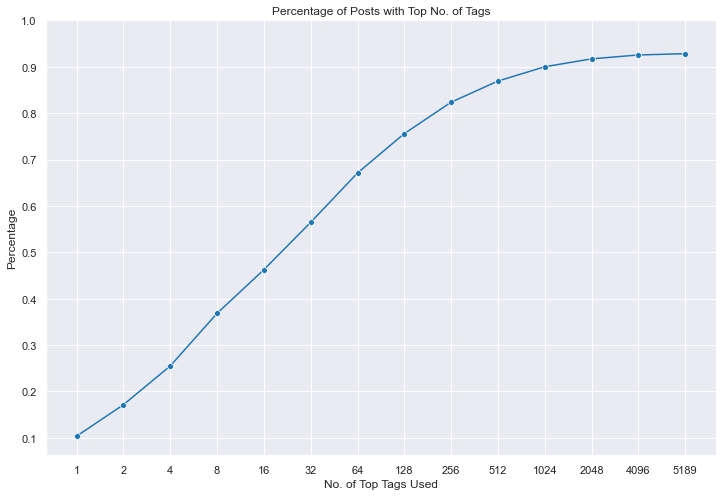

In [113]:
# Here, I'll do some data engineering to find the % of posts with n number of the top tags (by count)

q14['text'] = q14['Title']+' '+q14['Body']
q14['text'] = q14['text'].apply(clean_text)

tag_per_id = tags14.groupby('Id').size()
id_per_tag = tags14.groupby('Tag').size()

tagid_df = pd.DataFrame()
tagid_df['Id'] = tag_per_id.index.values
tagid_df['tag_count'] = tag_per_id.values

idtag_df = pd.DataFrame()
idtag_df['tag'] = id_per_tag.index.values
idtag_df['id_count'] = id_per_tag.values

idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)

top_tag_counts = [str(2**x) for x in range(0,13)]+[str(len(idtag_df))]
top_tag_pcts = []
for count in top_tag_counts:
    top_tags = list(idtag_df.iloc[-(int(count)+1):-1]['tag'])
    top_tag_pcts.append(len(tags14[tags14['Tag'].isin(top_tags)].groupby('Id').size())/len(tagid_df))
    
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x=top_tag_counts, y=top_tag_pcts, marker='o')

ax.set_yticks([x/10 for x in range(1,11)])
ax.set_xticks(top_tag_counts)

ax.set_title("Percentage of Posts with Top No. of Tags")
ax.set_xlabel('No. of Top Tags Used')
ax.set_ylabel('Percentage');

Once we hit 256 tags, we're dealing with over 80% of posts, so this is a good place to start our experiments.

In [114]:
top_256 = idtag_df.iloc[-256:].tag.values

raw_y = []
for index, row in q14[['tags']].iterrows():
    raw_y.append(set([x for x in row['tags'] if x in top_256]))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(raw_y)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(q14['text'], encoded_y,\
                                                    random_state=42, test_size=0.2)

for chunk in [X_train, X_test, y_train, y_test]:
    print(chunk.shape)

(23584,)
(5896,)
(23584, 256)
(5896, 256)


In [116]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Baseline Models

* Classifier Chain - using random forest classifier

* OneVsRest Classifier - using SGD/logistic classifier

In [117]:
classifier_chain_model = ClassifierChain(RandomForestClassifier())

In [118]:
t0 = time()
classifier_chain_model.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
print('Hamming loss for test data :', hamming_loss(classifier_chain_model,\
                                                   X_train, y_train, X_test, y_test))
test_time = time() - t0
print("test time: %0.3fs" % test_time)

train time: 802.987s
Hamming loss for test data : 0.004890762805291723
test time: 40.437s


## Top-20 Scoring

First, I'll focus on generating the scores for:

- Average suggestion score across all tags (whether the tag appears in predicted top-20 list)
- Proportion of posts perfectly predicted
- Average score across all posts (proportion of tags present in top-20 list)

In [119]:
def top20_score(clf, mlb, X_test, y_test):
    y_pred = clf.predict_proba(X_test)
    
    zipped_preds = [list(zip(list(mlb.classes_), list(x))) for x in y_pred]
    zip_sorted = [sorted(zipped_preds[i], key=lambda x: x[1], reverse=True) for i in range(len(zipped_preds))]
    
    tag_scores = []
    post_scores = []
    for i, x in enumerate(mlb.inverse_transform(y_test)):
        post_score = 0
        labels, probs = zip(*zip_sorted[i])
        for y in x:
            if y in labels[:20]:
                tag_scores.append(1)
                post_score += 1
            else:
                tag_scores.append(0)
        if x:
            post_scores.append(post_score/len(x))
            
    ones = 0
    for x in post_scores:
        if x == 1:
            ones += 1
    
    return np.mean(tag_scores), ones/len(y_test), np.mean(post_scores)

In [120]:
sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=10**-6, penalty='l1'), n_jobs=-1)
sgd_log_clf.fit(X_train, y_train)
predictions = sgd_log_clf.predict(X_test)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions, zero_division=0))

accuracy : 0.34362279511533245
macro f1 score : 0.3925619155016527
micro f1 scoore : 0.7525523378222699
hamming loss : 0.004126870971845319
Precision recall report :
               precision    recall  f1-score   support

           0       0.75      0.35      0.48        17
           1       0.39      0.20      0.26        46
           2       0.71      0.45      0.56        11
           3       0.55      0.60      0.57        10
           4       0.50      0.50      0.50        16
           5       0.25      0.12      0.17         8
           6       1.00      0.48      0.65        21
           7       0.00      0.00      0.00        19
           8       0.33      0.14      0.20         7
           9       0.00      0.00      0.00         8
          10       1.00      0.93      0.96        14
          11       1.00      0.12      0.22         8
          12       0.53      0.37      0.44       110
          13       0.50      0.27      0.35        11
          14       0.0

In [121]:
t0 = time()
sgd_log_clf.fit(X_train, y_train)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

t0 = time()
print('Hamming loss for test data :', hamming_loss(sgd_log_clf,\
                                                   X_train, y_train, X_test, y_test))
test_time = time() - t0
print("test time: %0.3fs" % test_time)

train time: 10.522s
Hamming loss for test data : 0.004158672193012212
test time: 0.326s


In [122]:
top20_score(sgd_log_clf, mlb, X_test, y_test)

(0.921173235563703, 0.8329375848032564, 0.9369798733604703)

## Initial results

Although these results look promising, I have a few concerns:

- Since we're only dealing with Python questions (all have the python tag), that leaves many with no tag BUT 'Python', so this should likely be directed at the larger '10% of Stack Overflow Questions' dataset.

***
***

# Using 10% of all SO Q&A dataset

I'll turn to the "10% of Stack Overflow Q&A" dataset:

https://www.kaggle.com/datasets/stackoverflow/stacksample?datasetId=265&sortBy=commentCount

This will allow the model to deal with a broader cross-section of questions, and be more directly applicable to a real-world implementation.

In [123]:
qbig = pd.read_csv('../data/QA_all/Questions.csv', encoding='latin1')
tbig = pd.read_csv('../data/QA_all/Tags.csv', encoding='latin1')

In [124]:
qbig.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [125]:
qbig['CreationDate'] = pd.to_datetime(qbig['CreationDate'], infer_datetime_format=True)

In [126]:
# Create initial subset (1 year of questions)

qbig2 = time_slice(qbig, 2015, 1, 2016, 1)

In [127]:
tbig2 = tbig[tbig['Id'].isin(qbig2['Id'].unique())]

In [128]:
len(qbig2), len(tbig2)

(230038, 693626)

In [129]:
qbig2['tags'] = qbig2['Id'].apply(lambda x: ([str(y) for y in list(tbig2[tbig2['Id']==x]['Tag'])]))

In [130]:
qbig2.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,tags
823129,27727410,541091.0,2015-01-01 00:06:41,NaN,0,Can Sequel be forced to always return autoincr...,<p>I'm working with Sequel (4.x) and MySQL 5.5...,"[mysql, ruby, sequel, on-duplicate-key]"
823130,27727520,4409403.0,2015-01-01 00:34:15,NaN,0,C# - Get Python logging stream,<p>i have a little question. Is it possible to...,"[c#, python, logging]"
823131,27727530,988445.0,2015-01-01 00:37:18,NaN,0,Receiving SIGSEGV (11) errors in many places,<p>I've been receiving <code>SIGSEGV (11)</cod...,"[delphi, firemonkey, sigsegv, delphi-xe7]"
823132,27727550,1461017.0,2015-01-01 00:42:04,NaN,3,Linux shell: Adding dots to numerical outputs ...,<p>This is a common output for <strong>some nu...,"[linux, bash, numbers]"
823133,27727560,3448171.0,2015-01-01 00:44:15,NaN,1,Login script in javascript failed,<p>Im creating login script which are based on...,"[javascript, php, login]"


## Cutoff point for tags

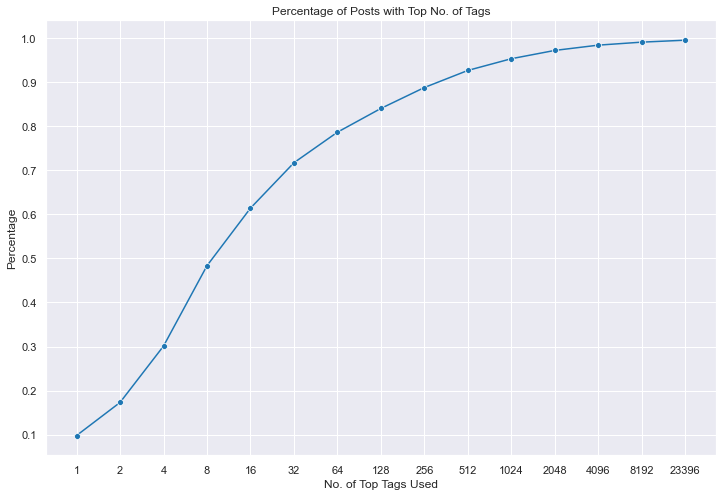

In [131]:
# Similar graph as above - what percentage of posts have at least one of the top n tags?

qbig2['text'] = qbig2['Title']+' '+qbig2['Body']
qbig2['text'] = qbig2['text'].apply(clean_text)

tag_per_id = tbig2.groupby('Id').size()
id_per_tag = tbig2.groupby('Tag').size()

tagid_df = pd.DataFrame()
tagid_df['Id'] = tag_per_id.index.values
tagid_df['tag_count'] = tag_per_id.values

idtag_df = pd.DataFrame()
idtag_df['tag'] = id_per_tag.index.values
idtag_df['id_count'] = id_per_tag.values

idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)

top_tag_counts = [str(2**x) for x in range(0,14)]+[str(len(idtag_df))]
top_tag_pcts = []
for count in top_tag_counts:
    top_tags = list(idtag_df.iloc[-(int(count)+1):-1]['tag'])
    top_tag_pcts.append(len(tbig2[tbig2['Tag'].isin(top_tags)].groupby('Id').size())/len(tagid_df))
    
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x=top_tag_counts, y=top_tag_pcts, marker='o')

ax.set_yticks([x/10 for x in range(1,11)])
ax.set_xticks(top_tag_counts)

ax.set_title("Percentage of Posts with Top No. of Tags")
ax.set_xlabel('No. of Top Tags Used')
ax.set_ylabel('Percentage');

In [132]:
y = []
for index, row in qbig2[['tags']].iterrows():
    y.append(set(row['tags']))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(y)

In [133]:
top_256 = idtag_df.iloc[-256:].tag.values

raw_y = []
for index, row in qbig2[['tags']].iterrows():
    raw_y.append(set([x for x in row['tags'] if x in top_256]))
    
mlb = MultiLabelBinarizer()
encoded_y = mlb.fit_transform(raw_y)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(qbig2['text'], encoded_y,\
                                                    random_state=42, test_size=0.2, )

for chunk in [X_train, X_test, y_train, y_test]:
    print(chunk.shape)

(184030,)
(46008,)
(184030, 256)
(46008, 256)


In [135]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Baseline Model

- This time, I'll just deal with the OneVsRest classifier - the chain classifier is prohibitive in training time, and didn't provide noticably different performance.
- I'll also include other metrics for now

In [136]:
t0 = time()

sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='log_loss'), n_jobs=-1)
sgd_log_clf.fit(X_train, y_train)
predictions = sgd_log_clf.predict(X_test)

train_time = time() - t0
print("train time: %0.3fs" % train_time)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions, zero_division=0))

train time: 68.940s
accuracy : 0.15206051121544079
macro f1 score : 0.03719886591106398
micro f1 scoore : 0.2530670762928827
hamming loss : 0.006192706974873935
Precision recall report :
               precision    recall  f1-score   support

           0       1.00      0.14      0.24       210
           1       0.00      0.00      0.00       509
           2       0.00      0.00      0.00        89
           3       0.00      0.00      0.00        87
           4       0.86      0.09      0.17       531
           5       0.00      0.00      0.00       264
           6       0.00      0.00      0.00        84
           7       0.00      0.00      0.00       177
           8       0.95      0.49      0.65      3476
           9       0.00      0.00      0.00        92
          10       0.00      0.00      0.00       162
          11       0.00      0.00      0.00        85
          12       0.00      0.00      0.00       127
          13       0.00      0.00      0.00       233
 

In [137]:
def top20_score(clf, mlb, X_test, y_test):
    y_pred = clf.predict_proba(X_test)
    
    zipped_preds = [list(zip(list(mlb.classes_), list(x))) for x in y_pred]
    zip_sorted = [sorted(zipped_preds[i], key=lambda x: x[1], reverse=True) for i in range(len(zipped_preds))]
    
    tag_scores = []
    post_scores = []
    for i, x in enumerate(mlb.inverse_transform(y_test)):
        post_score = 0
        labels, probs = zip(*zip_sorted[i])
        for y in x:
            if y in labels[:20]:
                tag_scores.append(1)
                post_score += 1
            else:
                tag_scores.append(0)
        if x:
            post_scores.append(post_score/len(x))
            
    ones = 0
    for x in post_scores:
        if x == 1:
            ones += 1
    
    return np.mean(tag_scores), ones/len(y_test), np.mean(post_scores)

In [138]:
top20_score(sgd_log_clf, mlb, X_test, y_test)

(0.810539705615119, 0.6177186576247609, 0.8251869446643794)

We see diminished performance in the top-20 scores, which is to be somewhat expected because of the greater diversity of questions, and the fact that there is no longer an automatic 'correct' tag ('python').

Let's test hyperparameters and see if we can get better results.

In [139]:
param_test_results = {
    'alpha_value' : [],
    'loss_metric' : [],
    'penalty_value' : [],
    'pct_tags_pred' : [],
    'pct_perfect' : [],
    'avg_post_score' : [],
    'hammingloss_score' : []
}

In [140]:
def append_data(a, l, p, pct_t, pct_p, avg_post_score, hls):
    param_test_results['alpha_value'].append(a)
    param_test_results['loss_metric'].append(l)
    param_test_results['penalty_value'].append(p)
    param_test_results['pct_tags_pred'].append(pct_p)
    param_test_results['pct_perfect'].append(pct_t)
    param_test_results['avg_post_score'].append(avg_post_score)
    param_test_results['hammingloss_score'].append(hls)

In [141]:
alphas = [10**-x for x in [3,4,5,6,7]]
losses = ['log_loss', 'modified_huber']
penalties = ['l1', 'l2']

for alpha in alphas:
    for loss in losses:
        for penalty in penalties:
            t0 = time()
            print("="*70)
            print(f'TESTING: alpha:{alpha} / loss:{loss} / penalty:{penalty}')
            sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss=loss, alpha=alpha, penalty=penalty), n_jobs=-1)
            sgd_log_clf.fit(X_train, y_train)
            predictions = sgd_log_clf.predict(X_test)
            train_time = time() - t0
            print("train time: %0.3fs" % train_time)
            
            hls = metrics.hamming_loss(y_test,predictions)
            top20_scores = top20_score(sgd_log_clf, mlb, X_test, y_test)
            append_data(alpha, loss, penalty, top20_scores[0], top20_scores[1], top20_scores[2], hls)
            

TESTING: alpha:0.001 / loss:log_loss / penalty:l1
train time: 111.746s
TESTING: alpha:0.001 / loss:log_loss / penalty:l2
train time: 79.672s
TESTING: alpha:0.001 / loss:modified_huber / penalty:l1
train time: 102.589s
TESTING: alpha:0.001 / loss:modified_huber / penalty:l2
train time: 57.980s
TESTING: alpha:0.0001 / loss:log_loss / penalty:l1
train time: 109.461s
TESTING: alpha:0.0001 / loss:log_loss / penalty:l2
train time: 68.098s
TESTING: alpha:0.0001 / loss:modified_huber / penalty:l1
train time: 94.544s
TESTING: alpha:0.0001 / loss:modified_huber / penalty:l2
train time: 54.883s
TESTING: alpha:1e-05 / loss:log_loss / penalty:l1
train time: 103.953s
TESTING: alpha:1e-05 / loss:log_loss / penalty:l2
train time: 72.664s
TESTING: alpha:1e-05 / loss:modified_huber / penalty:l1
train time: 145.969s
TESTING: alpha:1e-05 / loss:modified_huber / penalty:l2
train time: 60.813s
TESTING: alpha:1e-06 / loss:log_loss / penalty:l1
train time: 124.945s
TESTING: alpha:1e-06 / loss:log_loss / penal

In [142]:
param_df = pd.DataFrame(param_test_results)
display(param_df)

,alpha_value,loss_metric,penalty_value,pct_tags_pred,pct_perfect,avg_post_score,hammingloss_score
0,1.000000e-03,log_loss,l1,0.341462,0.565485,0.586562,0.006740
1,1.000000e-03,log_loss,l2,0.397822,0.623381,0.642168,0.006958
2,1.000000e-03,modified_huber,l1,0.637824,0.826289,0.838443,0.005934
3,1.000000e-03,modified_huber,l2,0.841028,0.960773,0.966448,0.006099
4,1.000000e-04,log_loss,l1,0.675513,0.852711,0.864955,0.005597
5,1.000000e-04,log_loss,l2,0.617806,0.810709,0.825366,0.006195
6,1.000000e-04,modified_huber,l1,0.809511,0.941002,0.945413,0.004958
7,1.000000e-04,modified_huber,l2,0.844853,0.963087,0.968805,0.004884
8,1.000000e-05,log_loss,l1,0.815315,0.944903,0.950953,0.004783
9,1.000000e-05,log_loss,l2,0.819727,0.947398,0.954060,0.005049


In [143]:
param_df['loss_penalty'] = param_df['loss_metric']+param_df['penalty_value']

In [144]:
param_df2 = param_df[['alpha_value', 'loss_penalty', 'pct_tags_pred']].copy()
param_df2['alpha_value'] = param_df2['alpha_value'].apply(str)

<AxesSubplot:xlabel='alpha_value', ylabel='pct_tags_pred'>

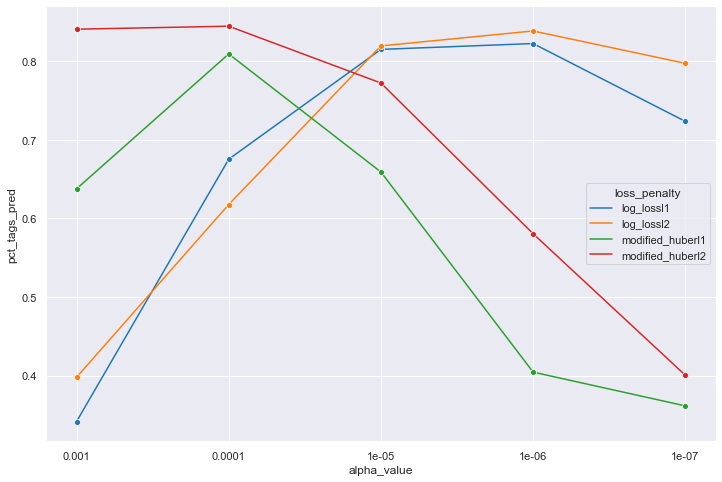

In [145]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=param_df2, x='alpha_value', y='pct_tags_pred', hue='loss_penalty', marker='o')

This graph gives us a look at the performance across 3 different hyperparamaters.

The best-performing model uses:

- alpha: 0.0001
- loss function: 'modified_huber'
- penalty: 'l2'

# Sample/Tag Tuning

Besides hyperparameters, I also need to experiment with:
- Number of samples
- Number of tags
- text-cleaning method

## Fitting best model to 500,000 posts

Let's attempt to build a much larger model, to see if the performance is better.

In [146]:
def fit_best_model(questions, tags, text_cleaner, n=500000, top=256):
    t0 = time()
    print('='*70)
    print('='*70)
    print('Prepping data...')
    
    if n == 0:
        n = len(questions)
    
    questions = questions.copy()
    questions = questions.iloc[-n:]
    
    questions['text'] = questions['Title']+' '+questions['Body']
    questions['text'] = questions['text'].apply(text_cleaner)
    questions['tags'] = questions['Id'].apply(lambda x: ([str(y) for y in list(tags[tags['Id']==x]['Tag'])]))
    
    print(f'Prep time: {time()-t0}')
    
    qTrain = questions.iloc[:-(int(n/5))]
    qTest = questions.iloc[-int(n/5):]
    print(f'# of posts in train set: {len(qTrain)}')
    print(f'# of posts in test set: {len(qTest)}')
    
    t0 = time()
    print('Prepping tag info...')
    tTrain = tags[tags['Id'].isin(qTrain['Id'].unique())]
    tTest = tags[tags['Id'].isin(qTest['Id'].unique())]
    
    tag_per_id = tTrain.groupby('Id').size()
    id_per_tag = tTrain.groupby('Tag').size()

    tagid_df = pd.DataFrame()
    tagid_df['Id'] = tag_per_id.index.values
    tagid_df['tag_count'] = tag_per_id.values

    idtag_df = pd.DataFrame()
    idtag_df['tag'] = id_per_tag.index.values
    idtag_df['id_count'] = id_per_tag.values

    idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
    idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)
    
    top_tags = idtag_df.iloc[-top:].tag.values

    raw_ytrain = []
    for index, row in qTrain[['tags']].iterrows():
        raw_ytrain.append(set([x for x in row['tags'] if x in top_tags]))

    raw_ytest = []
    for index, row in qTest[['tags']].iterrows():
        raw_ytest.append(set([x for x in row['tags'] if x in top_tags]))
    print(f'Tag prep time: {time()-t0}')
    
    t0 = time()
    print('Encoding labels...')
    mlb = MultiLabelBinarizer()
    y_train = mlb.fit_transform(raw_ytrain)
    y_test = mlb.transform(raw_ytest)
    
    print('Vectorizing text...')
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(qTrain['text'])
    X_test = vectorizer.transform(qTest['text'])
    print(f'Encoding/vectorizing time: {time()-t0}')
    
    
    t0 = time()
    print("="*70)
    print('Fitting model...')
    sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2'), n_jobs=-1)
    sgd_log_clf.fit(X_train, y_train)
    print('Generating predictions...')
    predictions = sgd_log_clf.predict(X_test)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    hls = metrics.hamming_loss(y_test,predictions)
    top20_scores = top20_score(sgd_log_clf, mlb, X_test, y_test)
    return {'hls':hls, 'top20scores':top20_scores}

As well, I'll quickly test the three text cleaning functions to see which I should use. I'll look at both performance and time efficiency.

In [147]:
best_scores = []

for text_cleaner in [clean_text, clean_text_2, clean_text_3]:
    best_scores.append(fit_best_model(qbig, tbig, text_cleaner))

Prepping data...
Prep time: 1153.1127648353577
# of posts in train set: 400000
# of posts in test set: 100000
Prepping tag info...
Tag prep time: 30.394689083099365
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 53.29170513153076
Fitting model...
Generating predictions...
train time: 128.662s
Prepping data...
Prep time: 1469.1151230335236
# of posts in train set: 400000
# of posts in test set: 100000
Prepping tag info...
Tag prep time: 30.234472036361694
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 34.68184232711792
Fitting model...
Generating predictions...
train time: 88.869s
Prepping data...
Prep time: 1429.6214060783386
# of posts in train set: 400000
# of posts in test set: 100000
Prepping tag info...
Tag prep time: 30.907652854919434
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 31.458186864852905
Fitting model...
Generating predictions...
train time: 84.872s


In [148]:
for score in best_scores:
    print(f'Hamming loss: ', score['hls'])
    print(f'Top 20 scores: ', score['top20scores'])

Hamming loss:  0.0048930859375
Top 20 scores:  (0.9642781154578233, 0.83011, 0.9693904620194186)
Hamming loss:  0.004956171875
Top 20 scores:  (0.9611096096009752, 0.82512, 0.9664825502750474)
Hamming loss:  0.0049547265625
Top 20 scores:  (0.9606610733816756, 0.82438, 0.9660393558180779)


It seems they all have very similar scores, so I'll go with the slightly faster clean_text_3 function.

## Smaller models by quarter

Because of the fluctuation of tags' usage over time, as new ones are introduced and older ones used less often (as seen at the end of the EDA notebook) I'll see if smaller, more temporally local models can perform better.

I'll use models built only with the questions in a particular quarter (3 months).

In [149]:
qbig = pd.read_csv('../data/QA_all/Questions.csv', encoding='latin1')
tbig = pd.read_csv('../data/QA_all/Tags.csv', encoding='latin1')

qbig['CreationDate'] = pd.to_datetime(qbig['CreationDate'], infer_datetime_format=True)

qbig['quarter'] = [x.quarter for x in qbig['CreationDate']]
qbig['year'] = [x.year for x in qbig['CreationDate']]
qbig['quarter'] = qbig['year'].apply(str).apply(lambda x: x[-2:]) + '-' + qbig['quarter'].apply(str)

all_quarters = list(qbig['quarter'].unique())

quarterly_scores = {'quarter':[], 'hamming_loss':[], 'top20_pct':[], 'top20_perfect':[]}

for quarter in all_quarters:
    this_q = qbig[qbig['quarter']==quarter]
    this_t = tbig[tbig['Id'].isin(this_q['Id'].unique())]
    quarterly_scores['quarter'].append(quarter)
    
    these_scores = fit_best_model(this_q, this_t, clean_text_3, n=0)
    
    quarterly_scores['hamming_loss'].append(these_scores['hls'])
    quarterly_scores['top20_pct'].append(these_scores['top20scores'][0])
    quarterly_scores['top20_perfect'].append(these_scores['top20scores'][1])
    
quarterly_df = pd.DataFrame(quarterly_scores)
display(quarterly_df)

Prepping data...
Prep time: 1.104508876800537
# of posts in train set: 1523
# of posts in test set: 380
Prepping tag info...
Tag prep time: 0.10854721069335938
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.06349992752075195
Fitting model...
Generating predictions...
train time: 1.100s
Prepping data...
Prep time: 2.3250770568847656
# of posts in train set: 3139
# of posts in test set: 784
Prepping tag info...
Tag prep time: 0.21928191184997559
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.1320488452911377
Fitting model...
Generating predictions...
train time: 0.329s
Prepping data...
Prep time: 3.681751012802124
# of posts in train set: 4399
# of posts in test set: 1099
Prepping tag info...
Tag prep time: 0.3078181743621826
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.20148205757141113
Fitting model...
Generating predictions...
train time: 0.531s
Prepping data...
Prep time: 5.042104244232178
# of posts in train set: 6092


Generating predictions...
train time: 4.046s
Prepping data...
Prep time: 37.74237895011902
# of posts in train set: 34217
# of posts in test set: 8554
Prepping tag info...
Tag prep time: 2.3483550548553467
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 2.1908621788024902
Fitting model...
Generating predictions...
train time: 4.294s
Prepping data...
Prep time: 39.82220196723938
# of posts in train set: 35480
# of posts in test set: 8869
Prepping tag info...
Tag prep time: 2.518666982650757
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 2.2823598384857178
Fitting model...
Generating predictions...
train time: 4.664s
Prepping data...
Prep time: 46.358758211135864
# of posts in train set: 39910
# of posts in test set: 9977
Prepping tag info...
Tag prep time: 2.77083420753479
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 2.661659002304077
Fitting model...
Generating predictions...
train time: 5.550s
Prepping data...
Prep time: 47.598

Encoding/vectorizing time: 4.128529787063599
Fitting model...
Generating predictions...
train time: 9.068s
Prepping data...
Prep time: 66.2515721321106
# of posts in train set: 50721
# of posts in test set: 12680
Prepping tag info...
Tag prep time: 3.562889814376831
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 4.0057761669158936
Fitting model...
Generating predictions...
train time: 9.067s
Prepping data...
Prep time: 14.169988870620728
# of posts in train set: 11672
# of posts in test set: 2918
Prepping tag info...
Tag prep time: 0.8407480716705322
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 0.8631899356842041
Fitting model...
Generating predictions...
train time: 1.177s


,quarter,hamming_loss,top20_pct,top20_perfect
0,08-3,0.006332,0.461883,0.250000
1,08-4,0.006467,0.644813,0.457908
2,09-1,0.005900,0.737755,0.545041
3,09-2,0.005695,0.778900,0.611038
4,09-3,0.005473,0.811051,0.639212
5,09-4,0.005354,0.815122,0.658844
6,10-1,0.005203,0.833501,0.689465
7,10-2,0.005270,0.830681,0.685237
8,10-3,0.005348,0.843642,0.692409
9,10-4,0.005140,0.851965,0.709585


As we move forward in time, more questions are present per quarter, and so we also see better performance. But still worse than the larger model.

## Exhaustive test of models - # of samples, # of top tags

Here, I'll test different combinations of # of samples (50000-200000) and # of top tags to use in the model (from 32 to 256).

In [150]:
grid_scores = {'samples':[], 'n_top':[], 'hamming_loss':[], 'top20_pct':[], 'top20_perfect':[]}

In [151]:
t0 = time()
print('='*70)
print('='*70)
print('Prepping data...')

q_clean = qbig.iloc[-200000:].copy()
print(f"Size of dataset: {len(q_clean)} samples")
q_clean['text'] = (q_clean['Title']+' ')*3 + q_clean['Body']
q_clean['text'] = q_clean['text'].apply(clean_text_3)
q_clean['tags'] = q_clean['Id'].apply(lambda x: ([str(y) for y in list(tbig[tbig['Id']==x]['Tag'])]))

print("prep time: %0.3fs" % (time() - t0))

Prepping data...
Size of dataset: 200000 samples
prep time: 592.340s


In [152]:
print('='*70)
print('='*70)

for size in [50000, 100000, 200000]:
    print(f"Prepping {size} samples for modelling")

    this_q = q_clean[-size:]
    this_t = tbig[tbig['Id'].isin(this_q['Id'].unique())]
    
    this_q = this_q.sample(frac=1, random_state=13).reset_index()
    
    q_train = this_q[:-(int(size/5))]
    q_test = this_q[(-int(size/5)):]
    t_train = this_t[this_t['Id'].isin(q_train['Id'].unique())]
    t_test = this_t[this_t['Id'].isin(q_test['Id'].unique())]
    
    print(f'# of posts in train set: {len(q_train)}')
    print(f'# of posts in test set: {len(q_test)}')

    tag_per_id = t_train.groupby('Id').size()
    id_per_tag = t_train.groupby('Tag').size()

    tagid_df = pd.DataFrame()
    tagid_df['Id'] = tag_per_id.index.values
    tagid_df['tag_count'] = tag_per_id.values

    idtag_df = pd.DataFrame()
    idtag_df['tag'] = id_per_tag.index.values
    idtag_df['id_count'] = id_per_tag.values

    idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
    idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)
    print('='*70)
    for top in [32, 64, 128, 256, 512]:
        print('='*70)
        print(f"Selecting top {top} tags...")
        top_tags = idtag_df.iloc[-top:].tag.values

        raw_ytrain = []
        for index, row in q_train[['tags']].iterrows():
            raw_ytrain.append(set([x for x in row['tags'] if x in top_tags]))

        raw_ytest = []
        for index, row in q_test[['tags']].iterrows():
            raw_ytest.append(set([x for x in row['tags'] if x in top_tags]))

        t0 = time()
        print('Encoding labels...')
        mlb = MultiLabelBinarizer()
        y_train = mlb.fit_transform(raw_ytrain)
        y_test = mlb.transform(raw_ytest)

        print('Vectorizing text...')
        vectorizer = TfidfVectorizer()

        X_train = vectorizer.fit_transform(q_train['text'])
        X_test = vectorizer.transform(q_test['text'])
        print(f'Encoding/vectorizing time: {time()-t0}')

        t0 = time()
        print("="*70)
        print('Fitting model...')
        sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2'), n_jobs=-1)
        sgd_log_clf.fit(X_train, y_train)
        print('Generating predictions...')
        predictions = sgd_log_clf.predict(X_test)
        train_time = time() - t0
        print("train time: %0.3fs" % train_time)

        hls = metrics.hamming_loss(y_test,predictions)
        top20_scores = top20_score(sgd_log_clf, mlb, X_test, y_test)
        
        grid_scores['samples'].append(size)
        grid_scores['n_top'].append(top)
        grid_scores['hamming_loss'].append(hls)
        grid_scores['top20_pct'].append(top20_scores[0])
        grid_scores['top20_perfect'].append(top20_scores[1])

Prepping 50000 samples for modelling
# of posts in train set: 40000
# of posts in test set: 10000
Selecting top 32 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.354578971862793
Fitting model...
Generating predictions...
train time: 2.122s
Selecting top 64 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.3448219299316406
Fitting model...
Generating predictions...
train time: 1.878s
Selecting top 128 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.3191049098968506
Fitting model...
Generating predictions...
train time: 3.495s
Selecting top 256 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.2961549758911133
Fitting model...
Generating predictions...
train time: 6.079s
Selecting top 512 tags...
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 3.38989520072937
Fitting model...
Generating predictions...
train time: 12.449s
Prepping 100000 samples for modelling
# o

In [153]:
grid_df = pd.DataFrame(grid_scores)
display(grid_df)

,samples,n_top,hamming_loss,top20_pct,top20_perfect
0,50000,32,0.019987,0.984644,0.697900
1,50000,64,0.012692,0.962912,0.747400
2,50000,128,0.007855,0.946941,0.777600
3,50000,256,0.004733,0.928526,0.777000
4,50000,512,0.002795,0.907598,0.761600
5,100000,32,0.020302,0.989652,0.708500
6,100000,64,0.012640,0.972011,0.761450
7,100000,128,0.007799,0.959313,0.796650
8,100000,256,0.004713,0.944503,0.806300
9,100000,512,0.002781,0.925573,0.797000


At this point, I'm concerned that I'm missing something in the 'top-20' scoring.

After altering the function below, we should see more realistic scores, since I didn't account for including ALL tags (not just tags in the model), both for the tag-prediction percentage, as well as the 'perfect' score.

In [154]:
def top20_score(y_pred, mlb, y_test):
    
    zipped_preds = [list(zip(list(mlb.classes_), list(x))) for x in y_pred]
    zip_sorted = [sorted(zipped_preds[i], key=lambda x: x[1], reverse=True) for i in range(len(zipped_preds))]
    
    all_labels = list(mlb.classes_)
    
    model_tag_scores = []
    tag_scores = []
    
    each_tag_scores = {}
    all_tags = t_test['Tag'].unique()
    for tag in all_tags:
        each_tag_scores[tag] = []
        
    post_scores = []
    for i, x in enumerate(y_test):
        post_score = 0
        labels, probs = zip(*zip_sorted[i])
        for y in x:
            if y in labels[:20]:
                tag_scores.append(1)
                model_tag_scores.append(1)
                each_tag_scores[y].append(1)
                post_score += 1
            else:
                tag_scores.append(0)
                if y in all_tags:
                    each_tag_scores[y].append(0)
                if y in labels and y in all_labels:
                    model_tag_scores.append(0)
        post_scores.append(post_score/len(x))
            
    ones = 0
    for x in post_scores:
        if x == 1:
            ones += 1
    
    return np.mean(post_scores), np.mean(tag_scores), np.mean(model_tag_scores),\
            ones/len(y_test), post_scores, each_tag_scores

In addition, I'll settle on 200,000 samples, and since the training time was relatively quick, I'll increase the number of tags included in the model to 2000.

## Final model - 200,000 samples, 2,000 tags

With a finalized top-20 scoring function, and new values for sample size and tag set size, I'll build the final model, and then visualize the results to see how they shake out in a few different ways.

In [155]:
grid_scores = {'samples':[], 'n_top':[], 'avg_post_score':[], 'pct_tags_top_n':[],\
               'pct_model_tags_top_n':[], 'pct_perfect':[], 'hamming_loss':[]}


print(f"Prepping {200000} samples for modelling")

this_t = tbig[tbig['Id'].isin(q_clean['Id'].unique())]

q_shuffled = q_clean.sample(frac=1, random_state=42).reset_index()

q_train = q_shuffled[:-40000]
q_test = q_shuffled[-40000:]
t_train = this_t[this_t['Id'].isin(q_train['Id'].unique())]
t_test = this_t[this_t['Id'].isin(q_test['Id'].unique())]

print(f'# of posts in train set: {len(q_train)}')
print(f'# of posts in test set: {len(q_test)}')

tag_per_id = t_train.groupby('Id').size()
id_per_tag = t_train.groupby('Tag').size()

tagid_df = pd.DataFrame()
tagid_df['Id'] = tag_per_id.index.values
tagid_df['tag_count'] = tag_per_id.values

idtag_df = pd.DataFrame()
idtag_df['tag'] = id_per_tag.index.values
idtag_df['id_count'] = id_per_tag.values

idtag_df['pct'] = idtag_df['id_count'] / len(tagid_df)
idtag_df = idtag_df.sort_values(by='pct', ascending=True).reset_index().drop('index', axis=1)
print('='*70)
top = 2000
print('='*70)
print(f"Selecting top {top} tags...")
top_tags = idtag_df.iloc[-top:].tag.values

top_tag_ids = t_train[t_train['Tag'].isin(top_tags)]
q_train = q_train[q_train['Id'].isin(top_tag_ids['Id'].unique())]
print(f'# of posts in trimmed train set: {len(q_train)}')

raw_ytrain = []
for index, row in q_train[['tags']].iterrows():
    raw_ytrain.append(set([x for x in row['tags'] if x in top_tags]))

raw_ytest = []
for index, row in q_test[['tags']].iterrows():
    raw_ytest.append(set([x for x in row['tags'] if x in top_tags]))

raw_ytest2 = []
for index, row in q_test[['tags']].iterrows():
    raw_ytest2.append(set([x for x in row['tags']]))

t0 = time()
print('Encoding labels...')
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(raw_ytrain)
y_test = mlb.transform(raw_ytest)

print('Vectorizing text...')
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(q_train['text'])
X_test = vectorizer.transform(q_test['text'])
print(f'Encoding/vectorizing time: {time()-t0}')

t0 = time()
print("="*70)
print('Fitting model...')
sgd_log_clf = OneVsRestClassifier(SGDClassifier(loss='modified_huber', alpha=0.0001, penalty='l2'), n_jobs=-1)
sgd_log_clf.fit(X_train, y_train)
print('Generating predictions...')
predictions = sgd_log_clf.predict(X_test)
train_time = time() - t0
print("train time: %0.3fs" % train_time)

Prepping 200000 samples for modelling
# of posts in train set: 160000
# of posts in test set: 40000
Selecting top 2000 tags...
# of posts in trimmed train set: 156068
Encoding labels...
Vectorizing text...
Encoding/vectorizing time: 13.833231210708618
Fitting model...
Generating predictions...
train time: 243.198s


In [156]:
t0 = time()
print('Scoring model (hamming)...')
hls = metrics.hamming_loss(y_test,predictions)
print('Scoring model (top 20 scoring)...')

y_pred = sgd_log_clf.predict_proba(X_test)
top20_scores = top20_score(y_pred, mlb, raw_ytest2)
score_time = time() - t0
print("Scoring time: %0.3fs" % score_time)

grid_scores['samples'].append(200000)
grid_scores['n_top'].append(top)
grid_scores['avg_post_score'].append(top20_scores[0])
grid_scores['pct_tags_top_n'].append(top20_scores[1])
grid_scores['pct_model_tags_top_n'].append(top20_scores[2])
grid_scores['pct_perfect'].append(top20_scores[3])
grid_scores['hamming_loss'].append(hls)

all_post_scores = top20_scores[4]

Scoring model (hamming)...
Scoring model (top 20 scoring)...
Scoring time: 513.416s


In [157]:
grid_df = pd.DataFrame(grid_scores)
display(grid_df)

,samples,n_top,avg_post_score,pct_tags_top_n,pct_model_tags_top_n,pct_perfect,hamming_loss
0,200000,2000,0.762914,0.743307,0.898286,0.486875,0.000923


## Score results

Here, was see lower scores than before, but this is due to the inclusion of all the non-top tags in the scoring.

The 'pct_model_tags_top_n' score shows that original scoring, while the 'pct_tags_top_n' gives the score across all tags in the test set.

Conversely, the hamming_loss score is much lower than before, likely because of the greater number of tags in the model.

***

## Visualizations

I'll look at a few different graphs of the results:

- Distribution of post scores (a small number of unique scores, since it's some fraction of 1 divisible by 1/2/3/4/5, as there are only 1-5 tags per post)
- Score proportions by number of tags per post
- Tag scores, organized by # of uses for each tag

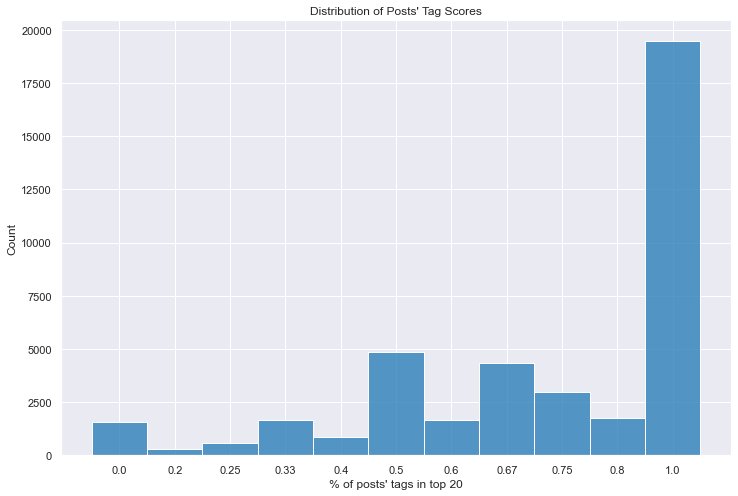

In [158]:
# Distribution of posts' top-20 prediction scores

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(x=sorted([str(round(x, 2)) for x in all_post_scores]))
ax.set_xlabel("% of posts' tags in top 20")
ax.set_title("Distribution of Posts' Tag Scores");

In [159]:
# Prep for more visualizations of results
# First, for top-20 score vs. number of tags in the post

q_test = q_clean[-40000:].copy()
q_test['n_tags'] = q_test['tags'].apply(len)

In [160]:
q_test['top20_score'] = all_post_scores

In [161]:
q_test[['tags','n_tags','top20_score']].groupby('n_tags').mean()

,top20_score
n_tags,
1,0.770889
2,0.761620
3,0.763974
4,0.761114
5,0.758918


In [162]:
q_test['top20_str'] = q_test['top20_score'].map(lambda x: round(x, 2)).map(str)

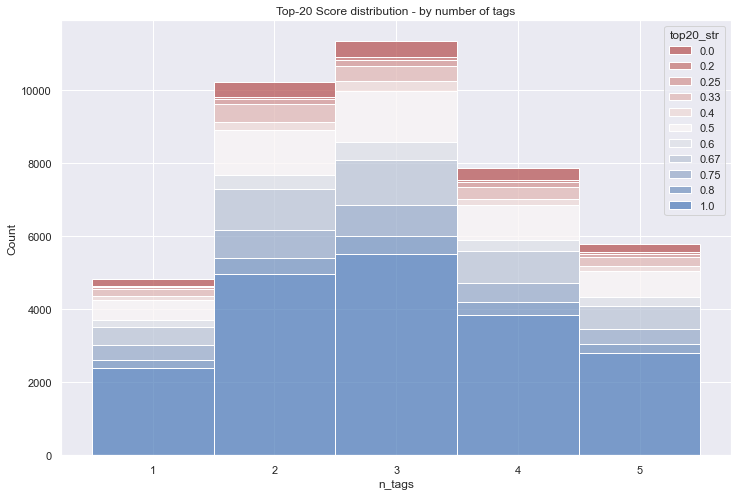

In [163]:
# Visualization of results - broken out by n_tags

fig, ax = plt.subplots(figsize=(12,8))

hue_order = sorted(q_test['top20_str'].unique(), reverse=False)
sns.histplot(data=q_test, x='n_tags', hue='top20_str', hue_order=hue_order,\
             palette='vlag_r', multiple='stack', discrete=True)

ax.set_xticks([1, 2, 3, 4, 5])
ax.set_title('Top-20 Score distribution - by number of tags');

In [164]:
# prep for visualization of scores per tag, relating to their usage counts

all_tag_scores = top20_scores[5]

In [165]:
all_tags = list(all_tag_scores.keys())
tag_scores = [np.mean(all_tag_scores[x]) if x else 0 for x in all_tags]
tag_scores

/Users/will/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/will/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.9684333593141076,
 0.9701417004048583,
 0.9287598944591029,
 0.5384615384615384,
 0.9523809523809523,
 0.9847425301970757,
 0.9835664335664336,
 0.0,
 0.8787878787878788,
 0.95,
 0.7692307692307693,
 0.0,
 0.0,
 0.9870178041543026,
 0.0,
 0.987459807073955,
 0.8428571428571429,
 0.9615384615384616,
 0.7952755905511811,
 0.7619047619047619,
 0.9904306220095693,
 0.9090909090909091,
 0.0,
 0.26666666666666666,
 0.993006993006993,
 0.0,
 0.9558897243107769,
 0.9621498864496594,
 0.9573643410852714,
 0.8571428571428571,
 0.977506248264371,
 0.9538461538461539,
 0.902200488997555,
 0.9117647058823529,
 0.7142857142857143,
 0.9702970297029703,
 0.8837209302325582,
 0.0,
 0.0,
 0.9202453987730062,
 0.976,
 0.9444444444444444,
 0.9333333333333333,
 0.4444444444444444,
 0.5416666666666666,
 0.8461538461538461,
 0.0,
 0.9719934102141681,
 0.9027777777777778,
 0.9615975422427036,
 0.8888888888888888,
 0.975609756097561,
 0.8842975206611571,
 0.9876543209876543,
 0.9090909090909091,
 0.97560975

In [166]:
viz_df = pd.DataFrame()
viz_df['tag'] = all_tags
viz_df['score'] = tag_scores
viz_df['count'] = [len(t_test[t_test['Tag']==tag]) for tag in all_tags]
display(viz_df)

,tag,score,count
0,c#,0.968433,2566
1,jquery,0.970142,1976
2,asp.net-mvc,0.928760,379
3,model-view-controller,0.538462,78
4,signalr,0.952381,21
...,...,...,...
12190,android-bundle,0.000000,1
12191,shape,0.000000,1
12192,cyclic,0.000000,1
12193,treelist,0.000000,1


In [167]:
viz_df = viz_df.sort_values(by='count', ascending=False)
viz_df = viz_df[['tag','score','count']]

In [168]:
# Second dataframe for calculating average score for >= n tag usage counts

viz_df2 = pd.DataFrame()
viz_df2['count'] = list(range(0,4500))
viz_df2['avg_score'] = [viz_df[viz_df['count']>=x]['score'].mean() for x in list(range(4500))]

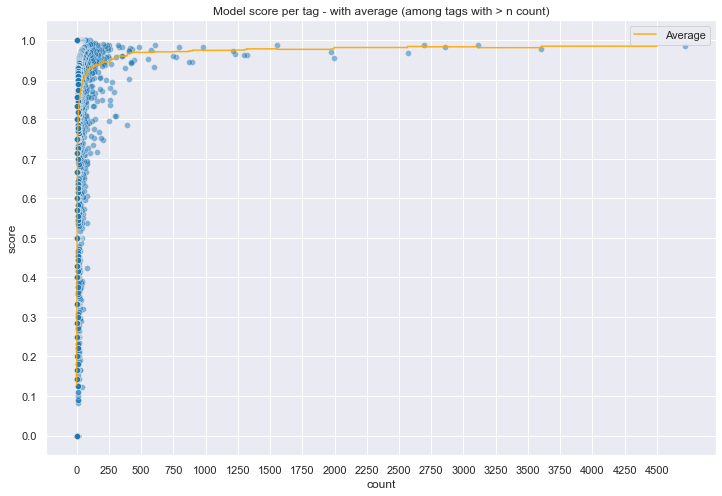

In [169]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=viz_df, x='count', y='score', alpha=.5)
sns.lineplot(data=viz_df2, x='count', y='avg_score', color='orange', alpha=.9, label='Average')
ax.set_xticks(list(range(0,4501,250)))
ax.set_yticks([x/10 for x in range(11)])
ax.set_title('Model score per tag - with average (among tags with > n count)')
plt.show()

This graph gives a look at the scores for each tag, plotted against that tag's count.

The orange line gives the average score for tags with >= that count.

This shows that the tags with at least 250 uses have > 80% top-20 prediction, and as you approach 0, the tags are pretty evenly spread across the score range.

---
Next, I'll graph the % of posts' tags that are NOT in the modelled tags.

In [170]:
bottom_tags = idtag_df.iloc[:-2000].tag.values

q_test['pct_bottom'] = q_test['tags'].apply(lambda x: [1 if y in bottom_tags else 0 for y in x])

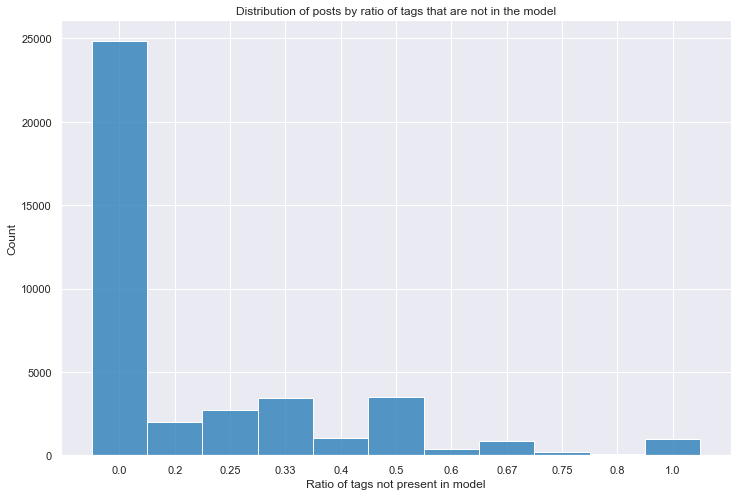

In [171]:
q_test['pct_bottom'] = q_test['pct_bottom'].apply(np.mean)

bottom_pcts = sorted([str(round(x,2)) for x in q_test['pct_bottom']])

fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(x=bottom_pcts, stat='count')
ax.set_title('Distribution of posts by ratio of tags that are not in the model')
ax.set_xlabel('Ratio of tags not present in model');

***
***
***

*********************
<a id="bottom"></a>
# 4. Conclusions
[Back to Top](#top) | [Previous Section](#t_p)

***
## Recommendations

In both components of this project, the results suggest that these features could feasibly be developed based on the performance of the models.

### Question Quality

Even using a relatively small sample of posts, this model can be used to alert users when their post is likely to be low-quality.

Because there is still a %15 chance or so of mis-classifying a post, the alert would likely need to be worded so as not to be definitively 'this is a bad post!'. Finding the right balance between being clear and being respectful would be paramount.

Assuming Stack Overflow has a vast collection of more data, a larger and more robust model could be built that could likely do even better at flagging low-quality posts.

Overall, the ability to alert users could save time (both human and on the technical backend) in having to identify poor questions and either reach out to have them edited, or remove them. As well, it would hopefully lead to users being more likely to revise their questions and end up with a better contribution to the community.

### Tag Suggestion

Similarly, the tag prediction model here shows that it's possible to extend its use to creating a top-20 list of suggested tags, and that the predictions are accurate and will likely lead to users better tagging their posts.

Based on analysis, using a model with data only from recent post history is likely the best choice, to make sure that up-to-date tag and question relationships are being included in the model. Also, the density of questions vs. time seems to be highest in the latest period of time (up to 2016) and would likely be even higher in more recent years.

## Limitations and Future Work

Especially with the Tag Suggestion model, more work could likely be done to increase the various metrics and scores, and ensure that more of the 'true' tags are included in the predicted top-20 lists. More memory and computational resources would allow for larger and more in-depth modelling, and exploration of different, more expensive but possibly higher-performing models.

* Specific to Tag Suggestion - The less-used tags are much harder to model and suggest accurately; this is likely also influencing the low-performing metrics for posts with >=3 tags, as I suspect that posts with only 1 or 2 tags use the more common tags, while the posts with more tags are more likely to have the less-used tags.

***

Beyond these models and goals, there are two areas I especially noticed might warrant further work.

### Tailored quality alerts

Exploration of whether there is a way to identify and alert users as to specific issues with a question that can be improved.

### Tag trend prediction

Exploration of whether predicting tag trends would be feasible, and possible connections to other datasets and intersections with the wider tech world.